<br> </br>
<font color='darkred' size = 7.5> <center>  <b> Quantitative strategies on high-frequency data </b> </center> </font>
<font color='darkred' size = 5> <center>  7. Optimization of a simple strategy </center> </font>
<br>
<font size = 5> <center> prof. Piotr Wójcik </center> </font>
<br> 
<font size = 5> <center>  academic year 2025/2026 </center> </font>

In [2]:
# lets load the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import quantstats as qs
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)  # ignore warnings
warnings.simplefilter(action="ignore", category=RuntimeWarning)  # ignore runtime warnings

# lets add the functions path to sys.path
import sys
sys.path.append('functions')

In [3]:
# lets load the quotations of currency futures

currencies = pd.read_parquet("currencies.parquet")

currencies.head()

,datetime,A6,E6,B6,C6,J6
0,2025-07-01 00:01:00+00:00,0.65694,1.17902,1.37390,0.734813,0.006950
1,2025-07-01 00:02:00+00:00,0.65688,1.17893,1.37396,0.734765,0.006950
2,2025-07-01 00:03:00+00:00,0.65670,1.17886,1.37386,0.734727,0.006951
3,2025-07-01 00:04:00+00:00,0.65671,1.17891,1.37397,0.734819,0.006951
4,2025-07-01 00:05:00+00:00,0.65664,1.17883,1.37391,0.734781,0.006949


In [4]:
# Lets set the datetime index

currencies['datetime'] = pd.to_datetime(currencies['datetime'])
currencies.set_index('datetime', inplace = True)

In [5]:
# data includes quotations (weighted average of bid and ask)
# of futures contracts for:
# E6 - EUR/USD
# J6 - JPY/USD
# A6 - AUD/USD
# C6 - CAD/USD
# B6 - GPB/USD

# one-minute data for one quarter (2025Q3)

# specifications of the contracts:
# E6 - point value = 125 000$, transaction cost = 10$
# J6 - point value = 12 500 000$, transaction cost = 10$
# A6 - point value = 100 000$, transaction cost = 10$
# C6 - point value = 100 000$, transaction cost = 10$
# B6 - point value = 62 500$, transaction cost = 10$

# IMPORTANT !!
# these currencies are traded almost 24 hours a day (except weekends)
# with a break between 17:00 and 18:00 (New York time - same as in the data)

In [6]:
# Let's split the data into training and test sets
# let's assume that data for the first two months (July and August) is for training
# and data for September is for testing

currencies_train = currencies[(currencies.index.month == 7) | (currencies.index.month == 8)]
currencies_test = currencies[currencies.index.month == 9]

currencies_train.tail()

,A6,E6,B6,C6,J6
datetime,,,,,
2025-08-31 23:55:00+00:00,0.65442,1.17045,1.35197,0.727966,0.006806
2025-08-31 23:56:00+00:00,0.65454,1.17059,1.35209,0.728009,0.006806
2025-08-31 23:57:00+00:00,0.65459,1.17073,1.35220,0.728035,0.006807
2025-08-31 23:58:00+00:00,0.65465,1.17075,1.35228,0.728056,0.006807
2025-08-31 23:59:00+00:00,0.65471,1.17082,1.35229,0.728051,0.006808


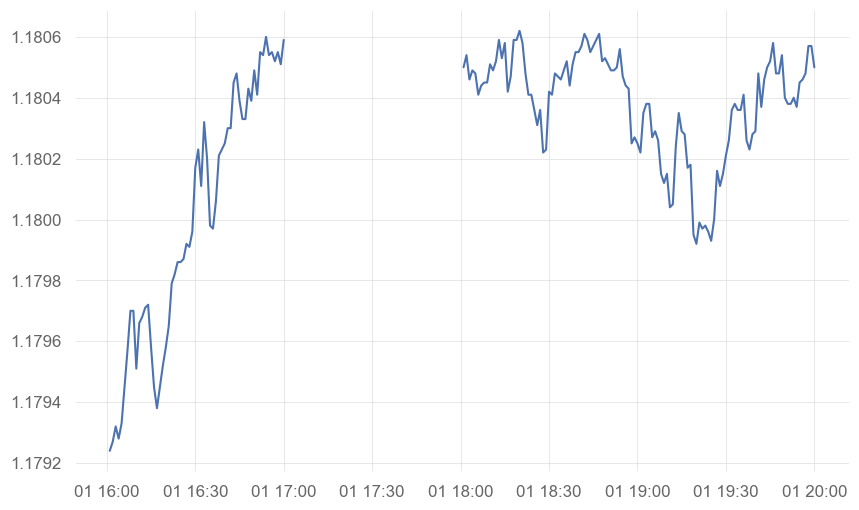

In [7]:
# Lets take E6 (EUR/USD) as an example

E6 = currencies_train['E6']

# check sample break in session

plt.figure(figsize = (10,6))
plt.plot(E6[960:1200])


C:\Users\hp\AppData\Local\Temp\ipykernel_3016\1762704899.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  E6.loc[E6.between_time("18:01", "18:05").index] = np.nan
C:\Users\hp\AppData\Local\Temp\ipykernel_3016\1762704899.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  E6.loc[E6.between_time("16:56", "17:00").index] = np.nan


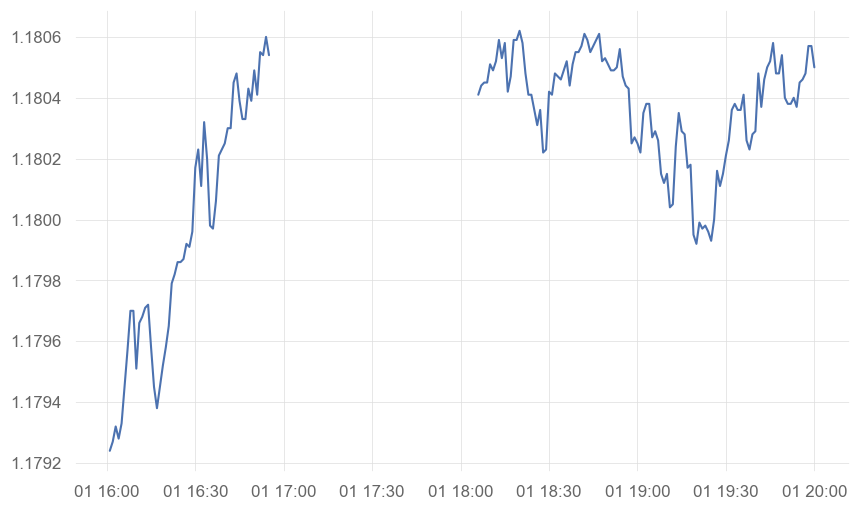

In [8]:
# initial assumptions about

# assumption 1
# we do not use the first 5 minutes of the session (18:01-18:05)
# and the last 5 minutes before the break (16:56-17:00) 
# let's insert missing data there

E6.loc[E6.between_time("18:01", "18:05").index] = np.nan
E6.loc[E6.between_time("16:56", "17:00").index] = np.nan

# let's see how the plot looks after inserting missing data

plt.figure(figsize = (10,6))
plt.plot(E6[960:1200])

# now the break in the data is longer

In [9]:
# assumption 2
# we do not trade during the first quarter of an hour after the break (18:00-18:15)
# and in the last quarter of an hour before the end of the session (16:46-17:00).
# Let's assume that we CLOSE ALL POSITIONS before the break (at 16:45).
# so finally, the position will always be 0 between 16:46 and 18:15.
# similarly as earlier, let's create an object named "pos_flat" 
# = 1 if position has to be flat (= 0) - we do not trade
# = 0 otherwise

# let's fill it first with zeros
pos_flat = np.zeros(len(E6))

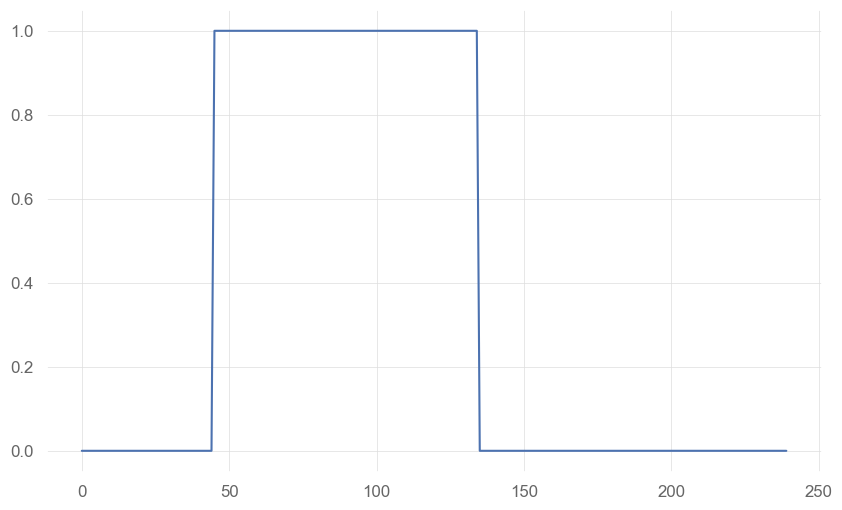

In [10]:
# put our assumptions into pos_flat
# we do not trade in the first quarter of an hour after the break (18:00-18:15)
# and in the last quarter of an hour after the break (16:46-17:00).
# Of course, we also do not trade during the break (17:00-18:00)

# Let's create a time mask based on the E6 index
breaks = (E6.index.time >= pd.to_datetime("16:46").time()) & \
          (E6.index.time <= pd.to_datetime("18:15").time())

# Assign 1 to pos_flat where the breaks mask is True
pos_flat[breaks] = 1

# let's see an example break in the session from the perspective of pos_flat

plt.figure(figsize = (10,6))
plt.plot(pos_flat[960:1200])

In [11]:
# lets check which weekdays we have data for

dweek_ = E6.index.dayofweek + 1  # Adjust so that 0 = Monday, ..., 6 = Sunday
print(dweek_.value_counts())

# no Saturdays in the data

datetime
4    12959
3    12957
2    12955
1    11520
5     9188
7     3771
Name: count, dtype: int64


In [12]:
# lets create a time_ object (vector of times)

time_ = E6.index.time

# and let's fill the pos_flat vector with ones for weekends

pos_flat[((dweek_ == 5) & (time_ > pd.to_datetime('17:00').time())) |      # end of Friday
          (dweek_ == 6) |                                                  # whole Saturday (just in case)
          ((dweek_ == 7) & (time_ <= pd.to_datetime('18:00').time()))] = 1 # beginning of Sunday

### Strategy 1: two intersecting moving averages

In [13]:
# we check various parameter combinations in a loop

def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)

fastEMA_parameters = [15, 20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240, 300, 360, 420]

# create a dataframe to store results
summary_all_2MAs = pd.DataFrame()

# Loop over different parameter combinations
for fastEMA in fastEMA_parameters:
    for slowEMA in slowEMA_parameters:
                
                # ensure that fastEMA is less than slowEMA
                if fastEMA >= slowEMA:
                    continue

                print(f"fastEMA = {fastEMA}, slowEMA = {slowEMA}")

                # We calculate the appropriate EMA
                fastEMA_values = E6.ewm(span = fastEMA).mean()
                slowEMA_values = E6.ewm(span = slowEMA).mean()

                # Insert NaNs wherever the original price is missing
                fastEMA_values[E6.isna()] = np.nan
                slowEMA_values[E6.isna()] = np.nan 

                # Calculate position for momentum strategy
                cond2b_mom_long = fastEMA_values.shift(1) > slowEMA_values.shift(1)
                
                # let's add filters that check for the presence of NaN values
                fastEMA_nonmiss = fastEMA_values.shift(1).notna()
                slowEMA_nonmiss = slowEMA_values.shift(1).notna()

                # Now we can add these conditions to our strategies
                # if any of the values is missing,
                # we cannot make a position decision

                pos_mom = np.where(fastEMA_nonmiss & slowEMA_nonmiss,
                                   np.where(cond2b_mom_long, 1, -1),
                                   np.nan)
                pos_mr = -pos_mom 

                # Set position to 0 where pos_flat is 1
                pos_mom[pos_flat == 1] = 0
                pos_mr[pos_flat == 1] = 0
                
                # Calculate gross pnl
                pnl_gross_mom = np.where(np.isnan(pos_mom * E6.diff()), 0, pos_mom * E6.diff() * 125000) 
                pnl_gross_mr = np.where(np.isnan(pos_mr * E6.diff()), 0, pos_mr * E6.diff() * 125000) 
                # point value for E6

                # Calculate number of transactions
                ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                # Calculate net pnl
                pnl_net_mom = pnl_gross_mom - ntrans * 10  # cost $10 per transaction on E6
                pnl_net_mr = pnl_gross_mr - ntrans * 10  # cost $10 per transaction on E6
                  
                # Aggregate to daily data
                pnl_gross_mom = pd.Series(pnl_gross_mom)
                pnl_gross_mom.index = E6.index.time
                pnl_gross_mom_d = pnl_gross_mom.groupby(E6.index.date).sum()
                pnl_gross_mr = pd.Series(pnl_gross_mr)
                pnl_gross_mr.index = E6.index.time
                pnl_gross_mr_d = pnl_gross_mr.groupby(E6.index.date).sum()

                pnl_net_mom = pd.Series(pnl_net_mom)
                pnl_net_mom.index = E6.index.time
                pnl_net_mom_d = pnl_net_mom.groupby(E6.index.date).sum()
                pnl_net_mr = pd.Series(pnl_net_mr)
                pnl_net_mr.index = E6.index.time
                pnl_net_mr_d = pnl_net_mr.groupby(E6.index.date).sum()

                ntrans = pd.Series(ntrans)
                ntrans.index = E6.index.time
                ntrans_d = ntrans.groupby(E6.index.date).sum()

                # Calculate Sharpe Ratio and PnL
                gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                gross_PnL_mom = pnl_gross_mom_d.sum()
                net_PnL_mom = pnl_net_mom_d.sum()
                gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                gross_PnL_mr = pnl_gross_mr_d.sum()
                net_PnL_mr = pnl_net_mr_d.sum()

                av_daily_ntrans = ntrans_d.mean()

                # Collect necessary results into one object
                summary = pd.DataFrame({
                    'fastEMA': fastEMA,
                    'slowEMA': slowEMA,
                    'period': '2013-08',
                    'gross_SR_mom': gross_SR_mom,
                    'net_SR_mom': net_SR_mom,
                    'gross_PnL_mom': gross_PnL_mom,
                    'net_PnL_mom': net_PnL_mom,
                    'gross_SR_mr': gross_SR_mr,
                    'net_SR_mr': net_SR_mr,
                    'gross_PnL_mr': gross_PnL_mr,
                    'net_PnL_mr': net_PnL_mr,
                    'av_daily_ntrans': av_daily_ntrans
                }, index=[0])

                # Append results to the summary
                summary_all_2MAs = pd.concat([summary_all_2MAs, summary], ignore_index=True)

fastEMA = 15, slowEMA = 90
fastEMA = 15, slowEMA = 120
fastEMA = 15, slowEMA = 150
fastEMA = 15, slowEMA = 180
fastEMA = 15, slowEMA = 240
fastEMA = 15, slowEMA = 300
fastEMA = 15, slowEMA = 360
fastEMA = 15, slowEMA = 420
fastEMA = 20, slowEMA = 90
fastEMA = 20, slowEMA = 120
fastEMA = 20, slowEMA = 150
fastEMA = 20, slowEMA = 180
fastEMA = 20, slowEMA = 240
fastEMA = 20, slowEMA = 300
fastEMA = 20, slowEMA = 360
fastEMA = 20, slowEMA = 420
fastEMA = 30, slowEMA = 90
fastEMA = 30, slowEMA = 120
fastEMA = 30, slowEMA = 150
fastEMA = 30, slowEMA = 180
fastEMA = 30, slowEMA = 240
fastEMA = 30, slowEMA = 300
fastEMA = 30, slowEMA = 360
fastEMA = 30, slowEMA = 420
fastEMA = 45, slowEMA = 90
fastEMA = 45, slowEMA = 120
fastEMA = 45, slowEMA = 150
fastEMA = 45, slowEMA = 180
fastEMA = 45, slowEMA = 240
fastEMA = 45, slowEMA = 300
fastEMA = 45, slowEMA = 360
fastEMA = 45, slowEMA = 420
fastEMA = 60, slowEMA = 90
fastEMA = 60, slowEMA = 120
fastEMA = 60, slowEMA = 150
fastEMA = 60, slowEMA = 1

In [14]:
# lets see top 5 stategies with respect to net_SR_mr
summary_all_2MAs.sort_values(by = 'net_SR_mr',
                            ascending = False).head(5)

,fastEMA,slowEMA,period,gross_SR_mom,net_SR_mom,gross_PnL_mom,net_PnL_mom,gross_SR_mr,net_SR_mr,gross_PnL_mr,net_PnL_mr,av_daily_ntrans
54,90,420,2013-08,0.556943,-1.864757,1090.0,-3781.25,-0.556943,-3.132304,-1090.0,-5938.75,9.169811
47,75,420,2013-08,0.696816,-1.863804,1385.0,-3866.25,-0.696816,-3.459843,-1385.0,-6613.75,9.886792
44,75,240,2013-08,0.364396,-2.505579,745.0,-5366.25,-0.364396,-3.487748,-745.0,-6833.75,11.509434
31,45,420,2013-08,0.321648,-2.715375,662.5,-5868.75,-0.321648,-3.629808,-662.5,-7171.25,12.301887
50,90,180,2013-08,0.386670,-2.781942,772.5,-5798.75,-0.386670,-3.796595,-772.5,-7321.25,12.377358


In [15]:
# lets import a function written by the lecturer
# to visualize the strategy results in a form of a heatmap
from functions.plot_heatmap import plot_heatmap

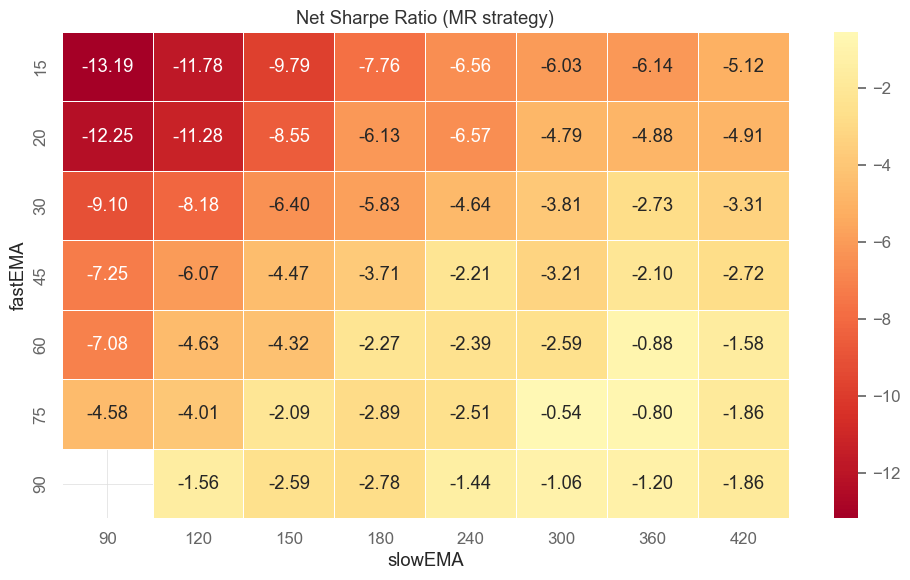

In [16]:
# we wil use it to visualize net SR values
# for the mean reversion strategy (MR)

plot_heatmap(
    summary_all_2MAs,
    value_col = 'net_SR_mom',
    index_col = 'fastEMA',
    columns_col = 'slowEMA',
    title = 'Net Sharpe Ratio (MR strategy)'
)

# none of the parameter combinations
# provides a positive net SR value

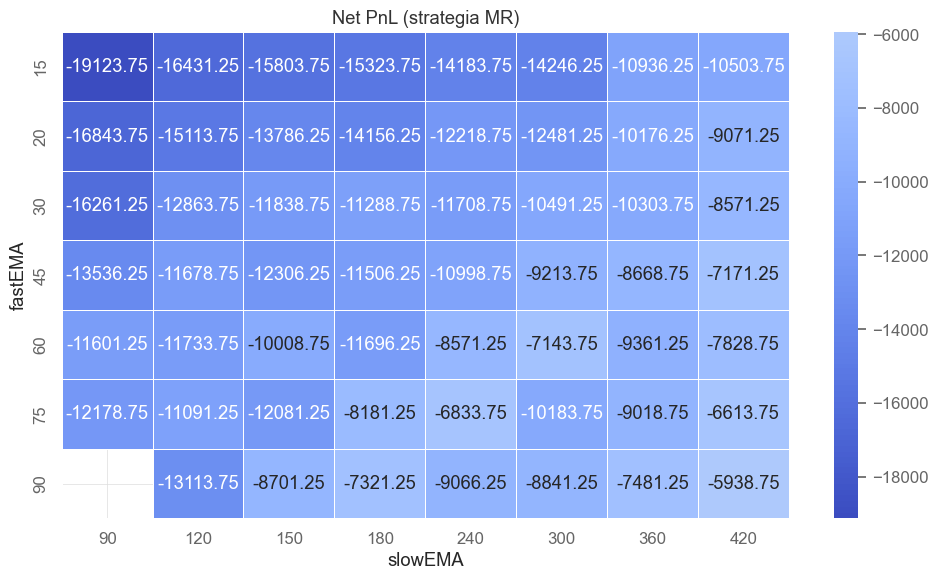

In [17]:
# zobaczmy teraz jak wygląda net PnL dla strategii MR

plot_heatmap(
    summary_all_2MAs,
    value_col = 'net_PnL_mr',
    index_col = 'fastEMA',
    columns_col = 'slowEMA',
    cmap = "coolwarm",
    title = 'Net PnL (strategia MR)'
)

### Strategy 2: volatility breakout

In [18]:
# lets use fastEMA as the strategy signal
# and use slowEMA+/-m*std as volatility boundaries

from functions.position_VB import positionVB

# we check various parameter combinations in a loop

signalEMA_parameters = [20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240]
volat_sd_parameters = [60, 90, 120]
m_parameters = [1, 2, 3]

# create a dataframe to store results
summary_all_breakout = pd.DataFrame()

# loop over different parameter combinations
for signalEMA in signalEMA_parameters:
    print(f"signalEMA = {signalEMA}")
    for slowEMA in slowEMA_parameters:
        for volat_sd in volat_sd_parameters:
            for m in m_parameters:
               
                # We calculate the appropriate EMA
                signalEMA_values = E6.ewm(span = signalEMA).mean().to_numpy()
                slowEMA_values = E6.ewm(span = slowEMA).mean().to_numpy()
                                
                # We calculate the standard deviation
                volat_sd_values = E6.rolling(window = volat_sd).std().to_numpy()

                # Insert NaNs wherever the original price is missing
                signalEMA_values[E6.isna()] = np.nan
                slowEMA_values[E6.isna()] = np.nan 
                volat_sd_values[E6.isna()] = np.nan 

                # Calculate position for momentum strategy
                pos_mom = positionVB(signal = signalEMA_values, 
                                     lower = slowEMA_values - m * volat_sd_values,
                                     upper = slowEMA_values + m * volat_sd_values,
                                     pos_flat = pos_flat,
                                     strategy = "mom")
                
                pos_mr = -pos_mom 

                # Calculate gross pnl
                pnl_gross_mom = np.where(np.isnan(pos_mom * E6.diff()), 0, pos_mom * E6.diff() * 125000) 
                pnl_gross_mr = np.where(np.isnan(pos_mr * E6.diff()), 0, pos_mr * E6.diff() * 125000) 
                # point value for E6

                # Calculate number of transactions
                ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                # Calculate net pnl
                pnl_net_mom = pnl_gross_mom - ntrans * 10  # cost $10 per transaction on E6
                pnl_net_mr = pnl_gross_mr - ntrans * 10  # cost $10 per transaction on E6
                  
                # Aggregate to daily data
                pnl_gross_mom = pd.Series(pnl_gross_mom)
                pnl_gross_mom.index = E6.index.time
                pnl_gross_mom_d = pnl_gross_mom.groupby(E6.index.date).sum()
                pnl_gross_mr = pd.Series(pnl_gross_mr)
                pnl_gross_mr.index = E6.index.time
                pnl_gross_mr_d = pnl_gross_mr.groupby(E6.index.date).sum()

                pnl_net_mom = pd.Series(pnl_net_mom)
                pnl_net_mom.index = E6.index.time
                pnl_net_mom_d = pnl_net_mom.groupby(E6.index.date).sum()
                pnl_net_mr = pd.Series(pnl_net_mr)
                pnl_net_mr.index = E6.index.time
                pnl_net_mr_d = pnl_net_mr.groupby(E6.index.date).sum()

                ntrans = pd.Series(ntrans)
                ntrans.index = E6.index.time
                ntrans_d = ntrans.groupby(E6.index.date).sum()

                # Calculate Sharpe Ratio and PnL
                gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                gross_PnL_mom = pnl_gross_mom_d.sum()
                net_PnL_mom = pnl_net_mom_d.sum()
                gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                gross_PnL_mr = pnl_gross_mr_d.sum()
                net_PnL_mr = pnl_net_mr_d.sum()

                av_daily_ntrans = ntrans_d.mean()

                # Collect the necessary results into one object
                summary = pd.DataFrame({
                    'signalEMA': signalEMA,
                    'slowEMA': slowEMA,
                    'volat_sd': volat_sd,
                    'm': m,
                    'period': '2013-08',
                    'gross_SR_mom': gross_SR_mom,
                    'net_SR_mom': net_SR_mom,
                    'gross_PnL_mom': gross_PnL_mom,
                    'net_PnL_mom': net_PnL_mom,
                    'gross_SR_mr': gross_SR_mr,
                    'net_SR_mr': net_SR_mr,
                    'gross_PnL_mr': gross_PnL_mr,
                    'net_PnL_mr': net_PnL_mr,
                    'av_daily_ntrans': av_daily_ntrans
                }, index=[0])

                # Append the results to the summary
                summary_all_breakout = pd.concat([summary_all_breakout, summary], ignore_index=True)

    # it takes a while
    # ca 2.5 minutes

signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90


In [19]:
# check 10 strategies with the best net_SR_mr

summary_all_breakout.sort_values(by = 'net_SR_mr', 
                                 ascending = False).head(10)

,signalEMA,slowEMA,volat_sd,m,period,gross_SR_mom,net_SR_mom,gross_PnL_mom,net_PnL_mom,gross_SR_mr,net_SR_mr,gross_PnL_mr,net_PnL_mr,av_daily_ntrans
34,20,180,120,2,2013-08,-3.621237,-4.259310,-7368.75,-8768.75,3.621237,2.966466,7368.75,5968.75,2.641509
41,20,240,90,3,2013-08,-3.711346,-4.463872,-6047.50,-7387.50,3.711346,2.932402,6047.50,4707.50,2.528302
88,30,240,120,2,2013-08,-3.520322,-4.194419,-7257.50,-8737.50,3.520322,2.830560,7257.50,5777.50,2.792453
178,60,240,120,2,2013-08,-3.621270,-4.410673,-4401.25,-5461.25,3.621270,2.798320,4401.25,3341.25,2.000000
191,75,120,60,3,2013-08,-2.838911,-3.001217,-1073.75,-1153.75,2.838911,2.667564,1073.75,993.75,0.150943
105,45,120,120,1,2013-08,-3.248904,-3.825239,-5601.25,-6681.25,3.248904,2.655543,5601.25,4521.25,2.037736
166,60,180,90,2,2013-08,-3.241758,-3.908310,-4658.75,-5698.75,3.241758,2.553213,4658.75,3618.75,1.962264
258,90,180,120,1,2013-08,-3.340315,-4.143134,-4452.50,-5612.50,3.340315,2.508243,4452.50,3292.50,2.188679
133,45,240,120,2,2013-08,-3.420858,-4.296567,-4427.50,-5667.50,3.420858,2.508086,4427.50,3187.50,2.339623
176,60,240,90,3,2013-08,-3.104510,-3.726690,-4247.50,-5167.50,3.104510,2.463329,4247.50,3327.50,1.735849


In [20]:
# the same for momentum

summary_all_breakout.sort_values(by = 'net_SR_mom',
                                 ascending = False).head(10)

,signalEMA,slowEMA,volat_sd,m,period,gross_SR_mom,net_SR_mom,gross_PnL_mom,net_PnL_mom,gross_SR_mr,net_SR_mr,gross_PnL_mr,net_PnL_mr,av_daily_ntrans
80,30,180,120,3,2013-08,2.619997,2.404288,1183.75,1063.75,-2.619997,-2.822166,-1183.75,-1303.75,0.226415
240,90,120,120,1,2013-08,2.201398,2.201398,116.25,96.25,-2.201398,-2.201398,-116.25,-136.25,0.037736
61,30,120,120,2,2013-08,2.201398,2.201398,52.50,32.50,-2.201398,-2.201398,-52.50,-72.50,0.037736
161,60,150,120,3,2013-08,2.201398,2.201398,52.50,32.50,-2.201398,-2.201398,-52.50,-72.50,0.037736
96,45,90,120,1,2013-08,2.201398,2.201398,52.50,32.50,-2.201398,-2.201398,-52.50,-72.50,0.037736
151,60,120,120,2,2013-08,2.201398,2.201398,52.50,32.50,-2.201398,-2.201398,-52.50,-72.50,0.037736
206,75,150,120,3,2013-08,2.201398,2.201398,35.00,15.00,-2.201398,-2.201398,-35.00,-55.00,0.037736
71,30,150,120,3,2013-08,2.201398,2.201398,33.75,13.75,-2.201398,-2.201398,-33.75,-53.75,0.037736
250,90,150,120,2,2013-08,2.201398,2.201398,42.50,22.50,-2.201398,-2.201398,-42.50,-62.50,0.037736
26,20,150,120,3,2013-08,2.201398,2.201398,36.25,16.25,-2.201398,-2.201398,-36.25,-56.25,0.037736


In [21]:
# summarize the results for the mr strategy
# in the form of a heatmap

# here we have four parameters
# signalEMA, slowEMA, volat_sd and m,
# so to present the results in the form of a heatmap,
# we need to combine them in pairs

summary_all_breakout["signalEMA_slowEMA"] = (
    summary_all_breakout["signalEMA"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout["slowEMA"].astype(int).astype(str).str.zfill(3)
)

summary_all_breakout["volat_sd_m"] = (
    summary_all_breakout["volat_sd"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout["m"].astype(str)
)

summary_all_breakout.head()


,signalEMA,slowEMA,volat_sd,m,period,gross_SR_mom,net_SR_mom,gross_PnL_mom,net_PnL_mom,gross_SR_mr,net_SR_mr,gross_PnL_mr,net_PnL_mr,av_daily_ntrans,signalEMA_slowEMA,volat_sd_m
0,20,90,60,1,2013-08,0.634766,-1.807507,1242.50,-3687.50,-0.634766,-3.277214,-1242.50,-6172.50,9.301887,020_090,060_1
1,20,90,60,2,2013-08,0.554292,-0.010094,1021.25,-18.75,-0.554292,-1.127421,-1021.25,-2061.25,1.962264,020_090,060_2
2,20,90,60,3,2013-08,-0.948394,-1.359925,-318.75,-458.75,0.948394,0.531800,318.75,178.75,0.264151,020_090,060_3
3,20,90,90,1,2013-08,1.811271,-0.299235,3592.50,-617.50,-1.811271,-4.084996,-3592.50,-7802.50,7.943396,020_090,090_1
4,20,90,90,2,2013-08,-1.977509,-2.523756,-135.00,-195.00,1.977509,1.212338,135.00,75.00,0.113208,020_090,090_2


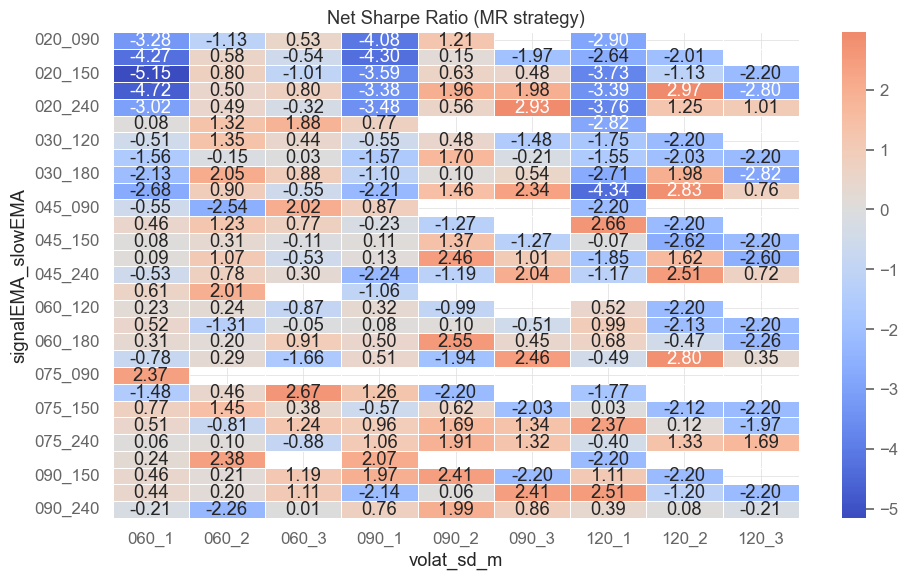

In [22]:
# now we can plot the heatmap
plot_heatmap(
    summary_all_breakout,
    value_col = 'net_SR_mr',
    index_col = 'signalEMA_slowEMA',
    columns_col = 'volat_sd_m',
    title = 'Net Sharpe Ratio (MR strategy)',
    cmap = "coolwarm"
)

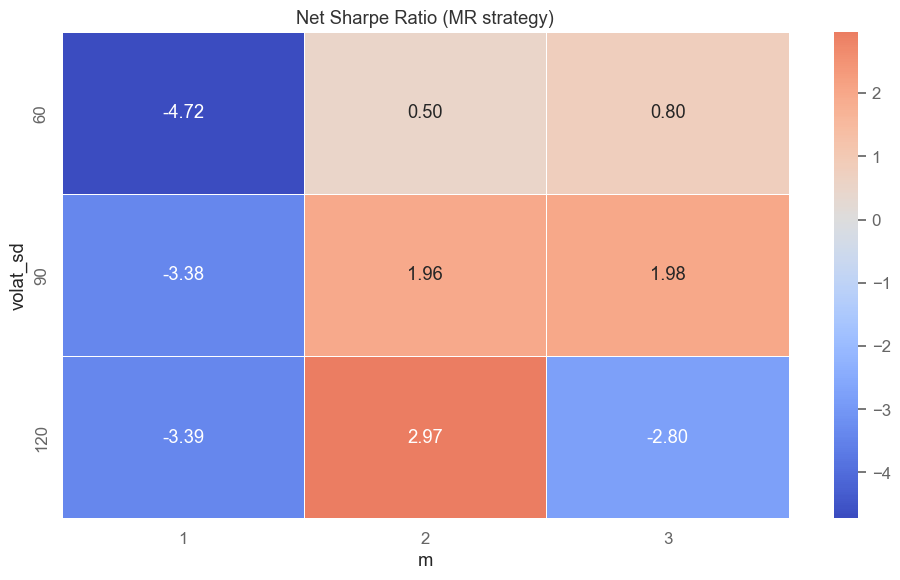

In [23]:
# the highest net SR are for signalEMA = 20 and slowEMA = 180

# let's check the sensitivity analysis of SR to m and volat_sd

# we select only rows with values of signalEMA and slowEMA
summary_all_breakout_wybrane = summary_all_breakout[
    (summary_all_breakout['signalEMA'] == 20) & (summary_all_breakout['slowEMA'] == 180)
]

# and we create a heatmap for them
plot_heatmap(
    summary_all_breakout_wybrane,
    value_col = 'net_SR_mr',
    index_col = 'volat_sd',
    columns_col = 'm',
    title = 'Net Sharpe Ratio (MR strategy)',
    cmap = "coolwarm"
)

# wygląda trochę jak anomalia, bo wokół wartości są sporo niższe

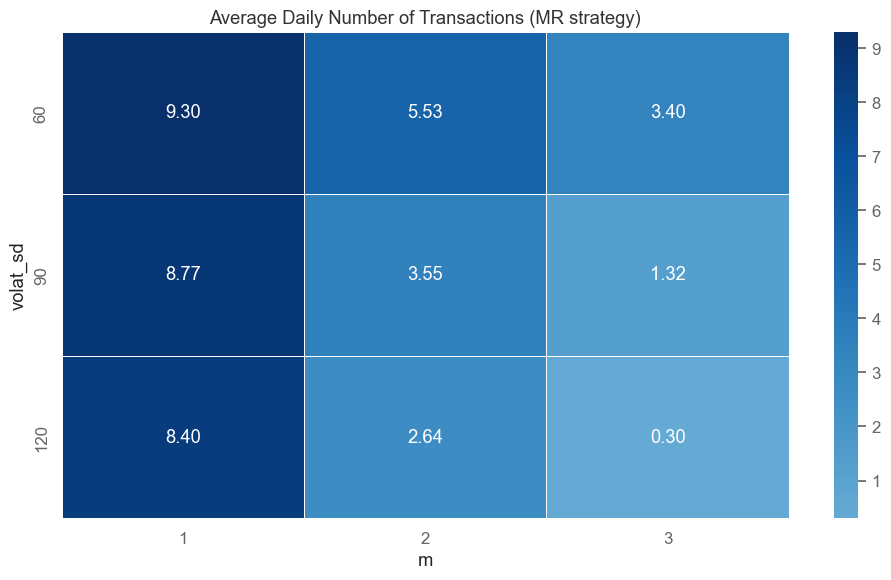

In [24]:
# heatmap plot can also be used to analyze transaction frequency

plot_heatmap(
    summary_all_breakout_wybrane,
    value_col = 'av_daily_ntrans',
    index_col = 'volat_sd',
    columns_col = 'm',
    title = 'Average Daily Number of Transactions (MR strategy)',
    cmap = "Blues")

    # in line with expectations
    # the larger the m, the fewer the transactions

# Exercises 7

# Exercise 7.1

Check the profitability of the same strategy on the test data for E6.

* Is the best-performing combination still profitable?
* How does its test net SR differ from that in the training data?
* Use graphs to verify the sensitivity of the results to the parameters.

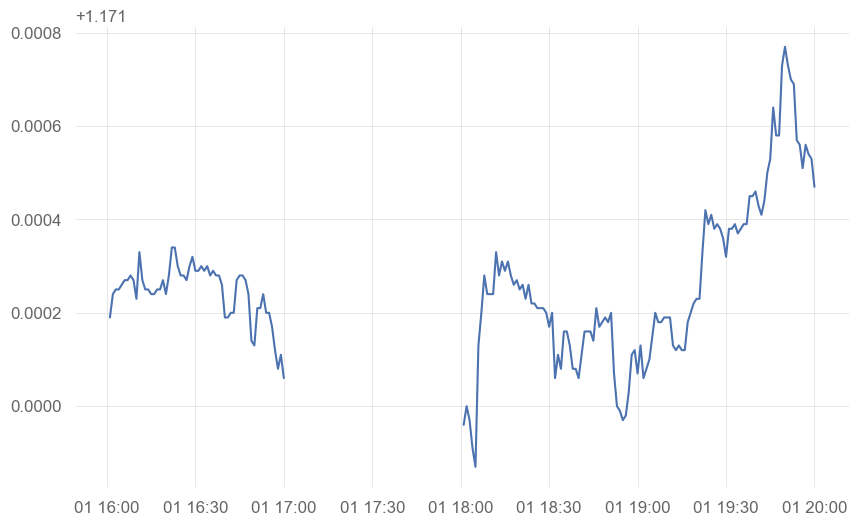

In [25]:
E6_test = currencies_test['E6']

# check sample break in session

plt.figure(figsize = (10,6))
plt.plot(E6_test[960:1200])


C:\Users\hp\AppData\Local\Temp\ipykernel_3016\2339187295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  E6_test.loc[E6_test.between_time("18:01", "18:05").index] = np.nan
C:\Users\hp\AppData\Local\Temp\ipykernel_3016\2339187295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  E6_test.loc[E6_test.between_time("16:56", "17:00").index] = np.nan


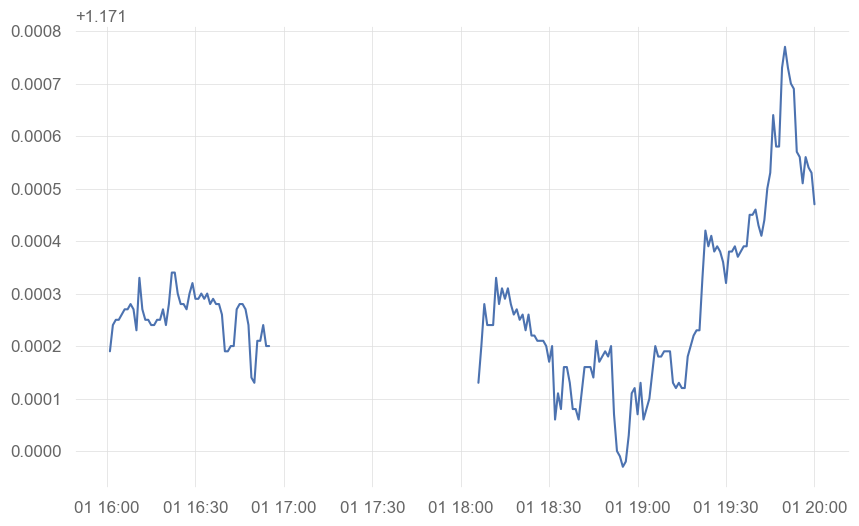

In [26]:
E6_test.loc[E6_test.between_time("18:01", "18:05").index] = np.nan
E6_test.loc[E6_test.between_time("16:56", "17:00").index] = np.nan

# let's see how the plot looks after inserting missing data

plt.figure(figsize = (10,6))
plt.plot(E6_test[960:1200])

In [27]:
pos_flat = np.zeros(len(E6_test))

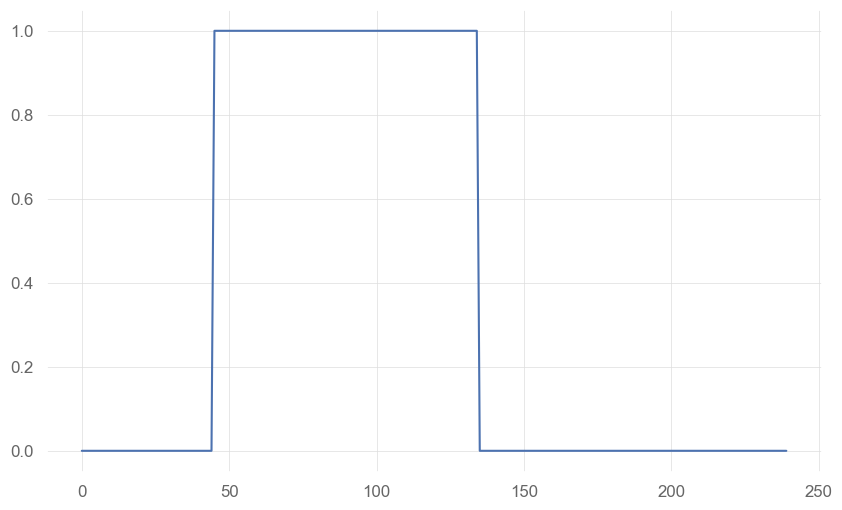

In [28]:
breaks = (E6_test.index.time >= pd.to_datetime("16:46").time()) & \
          (E6_test.index.time <= pd.to_datetime("18:15").time())

# Assign 1 to pos_flat where the breaks mask is True
pos_flat[breaks] = 1

# let's see an example break in the session from the perspective of pos_flat

plt.figure(figsize = (10,6))
plt.plot(pos_flat[960:1200])

In [29]:
dweek_ = E6_test.index.dayofweek + 1  # Adjust so that 0 = Monday, ..., 6 = Sunday
print(dweek_.value_counts())

datetime
2    7199
1    7198
3    5760
4    5760
5    4084
7    1672
Name: count, dtype: int64


In [30]:
time_ = E6_test.index.time

# and let's fill the pos_flat vector with ones for weekends

pos_flat[((dweek_ == 5) & (time_ > pd.to_datetime('17:00').time())) |      # end of Friday
          (dweek_ == 6) |                                                  # whole Saturday (just in case)
          ((dweek_ == 7) & (time_ <= pd.to_datetime('18:00').time()))] = 1 # beginning of Sunday

In [39]:
def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)

fastEMA_parameters = [15, 20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240, 300, 360, 420]

# create a dataframe to store results
summary_all_2MAs = pd.DataFrame()

# Loop over different parameter combinations
for fastEMA in fastEMA_parameters:
    for slowEMA in slowEMA_parameters:
                
                # ensure that fastEMA is less than slowEMA
                if fastEMA >= slowEMA:
                    continue

                print(f"fastEMA = {fastEMA}, slowEMA = {slowEMA}")

                # We calculate the appropriate EMA
                fastEMA_values = E6_test.ewm(span = fastEMA).mean()
                slowEMA_values = E6_test.ewm(span = slowEMA).mean()

                # Insert NaNs wherever the original price is missing
                fastEMA_values[E6_test.isna()] = np.nan
                slowEMA_values[E6_test.isna()] = np.nan 

                # Calculate position for momentum strategy
                cond2b_mom_long = fastEMA_values.shift(1) > slowEMA_values.shift(1)
                
                # let's add filters that check for the presence of NaN values
                fastEMA_nonmiss = fastEMA_values.shift(1).notna()
                slowEMA_nonmiss = slowEMA_values.shift(1).notna()

                # Now we can add these conditions to our strategies
                # if any of the values is missing,
                # we cannot make a position decision

                pos_mom = np.where(fastEMA_nonmiss & slowEMA_nonmiss,
                                   np.where(cond2b_mom_long, 1, -1),
                                   np.nan)
                pos_mr = -pos_mom 

                # Set position to 0 where pos_flat is 1
                pos_mom[pos_flat == 1] = 0
                pos_mr[pos_flat == 1] = 0
                
                # Calculate gross pnl
                pnl_gross_mom = np.where(np.isnan(pos_mom * E6_test.diff()), 0, pos_mom * E6_test.diff() * 125000) 
                pnl_gross_mr = np.where(np.isnan(pos_mr * E6_test.diff()), 0, pos_mr * E6_test.diff() * 125000) 
                # point value for E6

                # Calculate number of transactions
                ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                # Calculate net pnl
                pnl_net_mom = pnl_gross_mom - ntrans * 10  # cost $10 per transaction on E6
                pnl_net_mr = pnl_gross_mr - ntrans * 10  # cost $10 per transaction on E6
                  
                # Aggregate to daily data
                pnl_gross_mom = pd.Series(pnl_gross_mom)
                pnl_gross_mom.index = E6_test.index.time
                pnl_gross_mom_d = pnl_gross_mom.groupby(E6_test.index.date).sum()
                pnl_gross_mr = pd.Series(pnl_gross_mr)
                pnl_gross_mr.index = E6_test.index.time
                pnl_gross_mr_d = pnl_gross_mr.groupby(E6_test.index.date).sum()

                pnl_net_mom = pd.Series(pnl_net_mom)
                pnl_net_mom.index = E6_test.index.time
                pnl_net_mom_d = pnl_net_mom.groupby(E6_test.index.date).sum()
                pnl_net_mr = pd.Series(pnl_net_mr)
                pnl_net_mr.index = E6_test.index.time
                pnl_net_mr_d = pnl_net_mr.groupby(E6_test.index.date).sum()

                ntrans = pd.Series(ntrans)
                ntrans.index = E6_test.index.time
                ntrans_d = ntrans.groupby(E6_test.index.date).sum()

                # Calculate Sharpe Ratio and PnL
                gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                gross_PnL_mom = pnl_gross_mom_d.sum()
                net_PnL_mom = pnl_net_mom_d.sum()
                gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                gross_PnL_mr = pnl_gross_mr_d.sum()
                net_PnL_mr = pnl_net_mr_d.sum()

                av_daily_ntrans = ntrans_d.mean()

                # Collect necessary results into one object
                summary = pd.DataFrame({
                    'fastEMA_test': fastEMA,
                    'slowEMA_test': slowEMA,
                    'period_test': '2013-09',
                    'gross_SR_mom_test': gross_SR_mom,
                    'net_SR_mom_test': net_SR_mom,
                    'gross_PnL_mom_test': gross_PnL_mom,
                    'net_PnL_mom_test': net_PnL_mom,
                    'gross_SR_mr_test': gross_SR_mr,
                    'net_SR_mr_test': net_SR_mr,
                    'gross_PnL_mr_test': gross_PnL_mr,
                    'net_PnL_mr_test': net_PnL_mr,
                    'av_daily_ntrans_test': av_daily_ntrans
                }, index=[0])

                # Append results to the summary
                summary_all_2MAs = pd.concat([summary_all_2MAs, summary], ignore_index=True)

fastEMA = 15, slowEMA = 90
fastEMA = 15, slowEMA = 120
fastEMA = 15, slowEMA = 150
fastEMA = 15, slowEMA = 180
fastEMA = 15, slowEMA = 240
fastEMA = 15, slowEMA = 300
fastEMA = 15, slowEMA = 360
fastEMA = 15, slowEMA = 420
fastEMA = 20, slowEMA = 90
fastEMA = 20, slowEMA = 120
fastEMA = 20, slowEMA = 150
fastEMA = 20, slowEMA = 180
fastEMA = 20, slowEMA = 240
fastEMA = 20, slowEMA = 300
fastEMA = 20, slowEMA = 360
fastEMA = 20, slowEMA = 420
fastEMA = 30, slowEMA = 90
fastEMA = 30, slowEMA = 120
fastEMA = 30, slowEMA = 150
fastEMA = 30, slowEMA = 180
fastEMA = 30, slowEMA = 240
fastEMA = 30, slowEMA = 300
fastEMA = 30, slowEMA = 360
fastEMA = 30, slowEMA = 420
fastEMA = 45, slowEMA = 90
fastEMA = 45, slowEMA = 120
fastEMA = 45, slowEMA = 150
fastEMA = 45, slowEMA = 180
fastEMA = 45, slowEMA = 240
fastEMA = 45, slowEMA = 300
fastEMA = 45, slowEMA = 360
fastEMA = 45, slowEMA = 420
fastEMA = 60, slowEMA = 90
fastEMA = 60, slowEMA = 120
fastEMA = 60, slowEMA = 150
fastEMA = 60, slowEMA = 1

In [40]:
summary_all_2MAs.sort_values(by = 'net_SR_mr_test',
                            ascending = False).head(5)

,fastEMA_test,slowEMA_test,period_test,gross_SR_mom_test,net_SR_mom_test,gross_PnL_mom_test,net_PnL_mom_test,gross_SR_mr_test,net_SR_mr_test,gross_PnL_mr_test,net_PnL_mr_test,av_daily_ntrans_test
45,75,300,2013-09,-1.711930,-4.316050,-1651.25,-4547.5,1.711930,-1.419800,1651.25,-1252.5,11.153846
51,90,240,2013-09,-1.490895,-4.416134,-1341.25,-4337.5,1.490895,-2.017232,1341.25,-1662.5,11.538462
42,75,150,2013-09,-2.822752,-6.944523,-2408.75,-6425.0,2.822752,-2.038112,2408.75,-1615.0,15.461538
43,75,180,2013-09,-1.934586,-5.709340,-1718.75,-5435.0,1.934586,-2.400590,1718.75,-2005.0,14.307692
38,60,360,2013-09,-1.207618,-4.200505,-1088.75,-4165.0,1.207618,-2.432970,1088.75,-1995.0,11.846154


The best 5 policies of test dataset is different from that of training dataset.  
The best net_SR of test dataset is higher than that of training dataset.

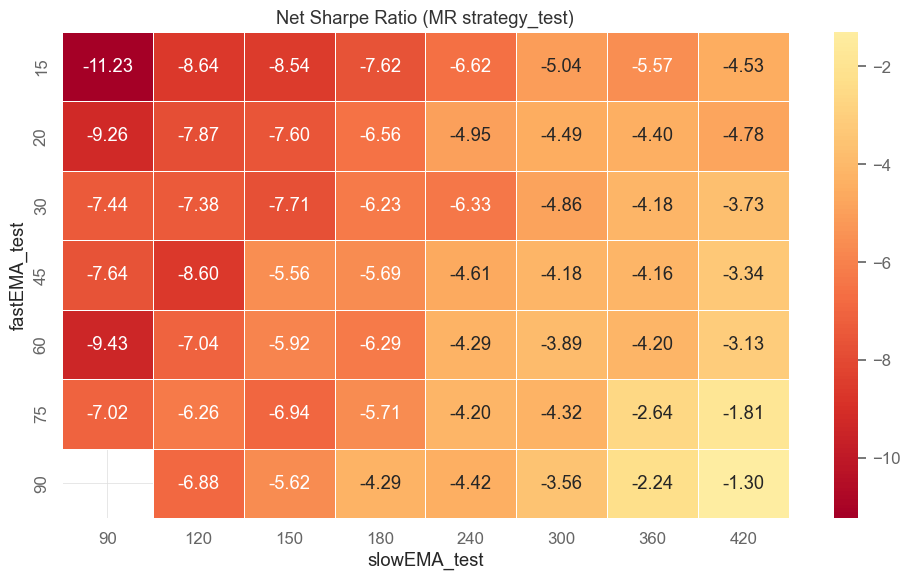

In [41]:
plot_heatmap(
    summary_all_2MAs,
    value_col = 'net_SR_mom_test',
    index_col = 'fastEMA_test',
    columns_col = 'slowEMA_test',
    title = 'Net Sharpe Ratio (MR strategy_test)'
)

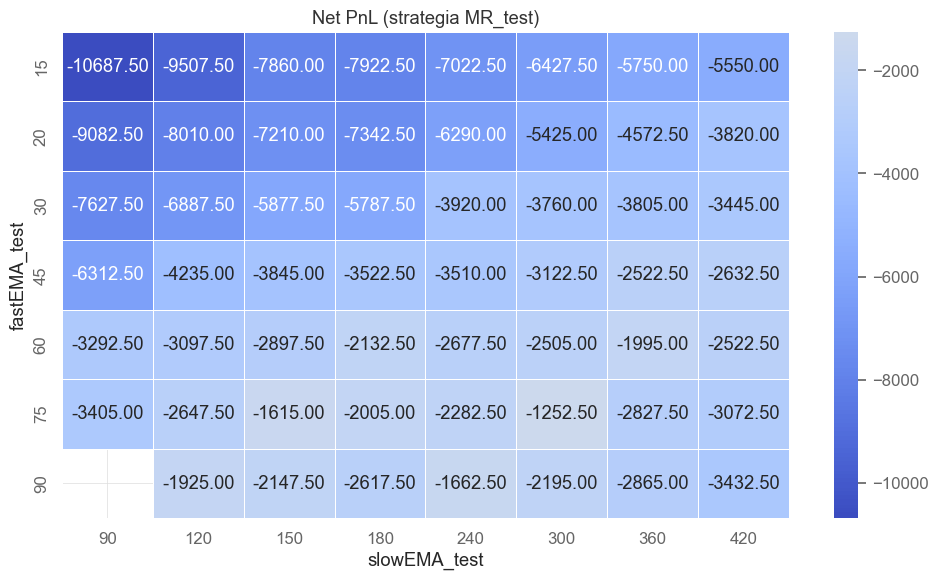

In [36]:
plot_heatmap(
    summary_all_2MAs,
    value_col = 'net_PnL_mr_test',
    index_col = 'fastEMA_test',
    columns_col = 'slowEMA_test',
    cmap = "coolwarm",
    title = 'Net PnL (strategia MR_test)'
)

In [42]:
from functions.position_VB import positionVB

# we check various parameter combinations in a loop

signalEMA_parameters = [20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240]
volat_sd_parameters = [60, 90, 120]
m_parameters = [1, 2, 3]

# create a dataframe to store results
summary_all_breakout = pd.DataFrame()

# loop over different parameter combinations
for signalEMA in signalEMA_parameters:
    print(f"signalEMA = {signalEMA}")
    for slowEMA in slowEMA_parameters:
        for volat_sd in volat_sd_parameters:
            for m in m_parameters:
               
                # We calculate the appropriate EMA
                signalEMA_values = E6_test.ewm(span = signalEMA).mean().to_numpy()
                slowEMA_values = E6_test.ewm(span = slowEMA).mean().to_numpy()
                                
                # We calculate the standard deviation
                volat_sd_values = E6_test.rolling(window = volat_sd).std().to_numpy()

                # Insert NaNs wherever the original price is missing
                signalEMA_values[E6_test.isna()] = np.nan
                slowEMA_values[E6_test.isna()] = np.nan 
                volat_sd_values[E6_test.isna()] = np.nan 

                # Calculate position for momentum strategy
                pos_mom = positionVB(signal = signalEMA_values, 
                                     lower = slowEMA_values - m * volat_sd_values,
                                     upper = slowEMA_values + m * volat_sd_values,
                                     pos_flat = pos_flat,
                                     strategy = "mom")
                
                pos_mr = -pos_mom 

                # Calculate gross pnl
                pnl_gross_mom = np.where(np.isnan(pos_mom * E6_test.diff()), 0, pos_mom * E6_test.diff() * 125000) 
                pnl_gross_mr = np.where(np.isnan(pos_mr * E6_test.diff()), 0, pos_mr * E6_test.diff() * 125000) 
                # point value for E6

                # Calculate number of transactions
                ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                # Calculate net pnl
                pnl_net_mom = pnl_gross_mom - ntrans * 10  # cost $10 per transaction on E6
                pnl_net_mr = pnl_gross_mr - ntrans * 10  # cost $10 per transaction on E6
                  
                # Aggregate to daily data
                pnl_gross_mom = pd.Series(pnl_gross_mom)
                pnl_gross_mom.index = E6_test.index.time
                pnl_gross_mom_d = pnl_gross_mom.groupby(E6_test.index.date).sum()
                pnl_gross_mr = pd.Series(pnl_gross_mr)
                pnl_gross_mr.index = E6_test.index.time
                pnl_gross_mr_d = pnl_gross_mr.groupby(E6_test.index.date).sum()

                pnl_net_mom = pd.Series(pnl_net_mom)
                pnl_net_mom.index = E6_test.index.time
                pnl_net_mom_d = pnl_net_mom.groupby(E6_test.index.date).sum()
                pnl_net_mr = pd.Series(pnl_net_mr)
                pnl_net_mr.index = E6_test.index.time
                pnl_net_mr_d = pnl_net_mr.groupby(E6_test.index.date).sum()

                ntrans = pd.Series(ntrans)
                ntrans.index = E6_test.index.time
                ntrans_d = ntrans.groupby(E6_test.index.date).sum()

                # Calculate Sharpe Ratio and PnL
                gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                gross_PnL_mom = pnl_gross_mom_d.sum()
                net_PnL_mom = pnl_net_mom_d.sum()
                gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                gross_PnL_mr = pnl_gross_mr_d.sum()
                net_PnL_mr = pnl_net_mr_d.sum()

                av_daily_ntrans = ntrans_d.mean()

                # Collect the necessary results into one object
                summary = pd.DataFrame({
                    'signalEMA_test': signalEMA,
                    'slowEMA_test': slowEMA,
                    'volat_sd_test': volat_sd,
                    'm_test': m,
                    'period_test': '2013-09',
                    'gross_SR_mom_test': gross_SR_mom,
                    'net_SR_mom_test': net_SR_mom,
                    'gross_PnL_mom_test': gross_PnL_mom,
                    'net_PnL_mom_test': net_PnL_mom,
                    'gross_SR_mr_test': gross_SR_mr,
                    'net_SR_mr_test': net_SR_mr,
                    'gross_PnL_mr_test': gross_PnL_mr,
                    'net_PnL_mr_test': net_PnL_mr,
                    'av_daily_ntrans_test': av_daily_ntrans
                }, index=[0])

                # Append the results to the summary
                summary_all_breakout = pd.concat([summary_all_breakout, summary], ignore_index=True)

signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90


In [43]:
summary_all_breakout.sort_values(by = 'net_SR_mr_test', 
                                 ascending = False).head(10)

,signalEMA_test,slowEMA_test,volat_sd_test,m_test,period_test,gross_SR_mom_test,net_SR_mom_test,gross_PnL_mom_test,net_PnL_mom_test,gross_SR_mr_test,net_SR_mr_test,gross_PnL_mr_test,net_PnL_mr_test,av_daily_ntrans_test
259,90,180,120,2,2013-09,-4.536790,-4.556786,-118.75,-158.75,4.536790,4.480404,118.75,78.75,0.153846
125,45,180,120,3,2013-09,-3.174902,-3.174902,-51.25,-71.25,3.174902,3.174902,51.25,31.25,0.076923
160,60,150,120,2,2013-09,-3.174902,-3.174902,-51.25,-71.25,3.174902,3.174902,51.25,31.25,0.076923
80,30,180,120,3,2013-09,-3.174902,-3.174902,-51.25,-71.25,3.174902,3.174902,51.25,31.25,0.076923
47,30,90,60,3,2013-09,-3.174902,-3.174902,-48.75,-68.75,3.174902,3.174902,48.75,28.75,0.076923
170,60,180,120,3,2013-09,-3.174902,-3.174902,-41.25,-61.25,3.174902,3.174902,41.25,21.25,0.076923
195,75,120,120,1,2013-09,-3.174902,-3.174902,-41.25,-61.25,3.174902,3.174902,41.25,21.25,0.076923
205,75,150,120,2,2013-09,-3.174902,-3.174902,-45.00,-65.00,3.174902,3.174902,45.00,25.00,0.076923
215,75,180,120,3,2013-09,-3.174902,-3.174902,-45.00,-65.00,3.174902,3.174902,45.00,25.00,0.076923
203,75,150,90,3,2013-09,-3.174902,-3.174902,-45.00,-65.00,3.174902,3.174902,45.00,25.00,0.076923


In [44]:
summary_all_breakout["signalEMA_slowEMA_test"] = (
    summary_all_breakout["signalEMA_test"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout["slowEMA_test"].astype(int).astype(str).str.zfill(3)
)

summary_all_breakout["volat_sd_m_test"] = (
    summary_all_breakout["volat_sd_test"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout["m_test"].astype(str)
)

summary_all_breakout.head()


,signalEMA_test,slowEMA_test,volat_sd_test,m_test,period_test,gross_SR_mom_test,net_SR_mom_test,gross_PnL_mom_test,net_PnL_mom_test,gross_SR_mr_test,net_SR_mr_test,gross_PnL_mr_test,net_PnL_mr_test,av_daily_ntrans_test,signalEMA_slowEMA_test,volat_sd_m_test
0,20,90,60,1,2013-09,-4.221223,-6.566321,-4128.75,-6668.75,4.221223,1.679567,4128.75,1588.75,9.769231,020_090,060_1
1,20,90,60,2,2013-09,3.532290,2.477542,1478.75,1038.75,-3.532290,-4.581694,-1478.75,-1918.75,1.692308,020_090,060_2
2,20,90,60,3,2013-09,-1.597995,-2.443500,-102.50,-162.50,1.597995,0.666484,102.50,42.50,0.230769,020_090,060_3
3,20,90,90,1,2013-09,-3.200839,-5.266579,-3098.75,-5278.75,3.200839,0.980066,3098.75,918.75,8.384615,020_090,090_1
4,20,90,90,2,2013-09,-1.158209,-1.712558,-73.75,-113.75,1.158209,0.543941,73.75,33.75,0.153846,020_090,090_2


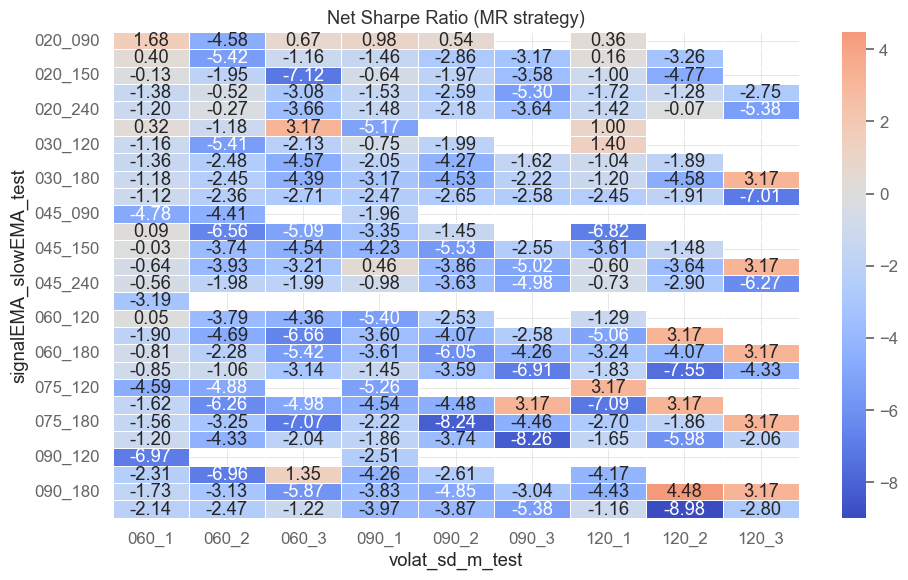

In [45]:
plot_heatmap(
    summary_all_breakout,
    value_col = 'net_SR_mr_test',
    index_col = 'signalEMA_slowEMA_test',
    columns_col = 'volat_sd_m_test',
    title = 'Net Sharpe Ratio (MR strategy)',
    cmap = "coolwarm"
)

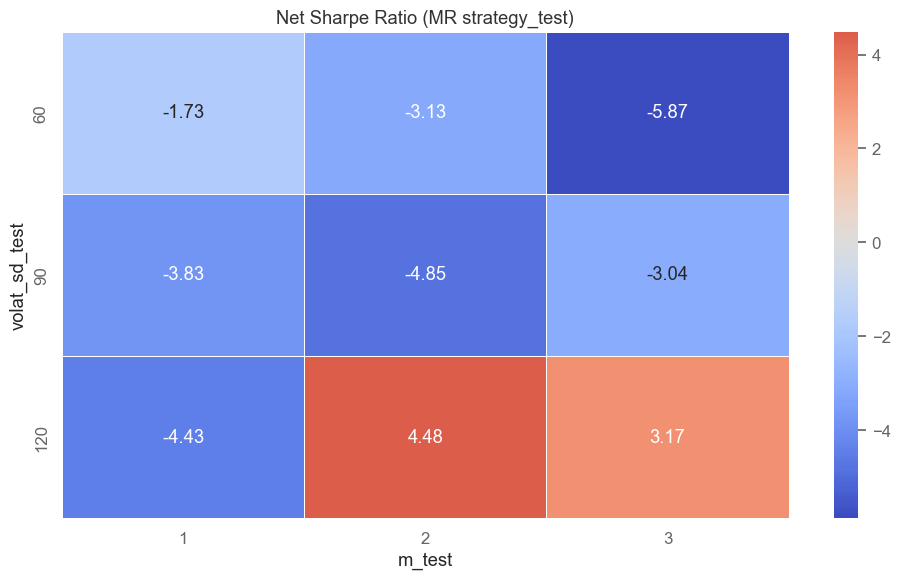

In [47]:
summary_all_breakout_selected = summary_all_breakout[
    (summary_all_breakout['signalEMA_test'] == 90) & (summary_all_breakout['slowEMA_test'] == 180)
]

# and we create a heatmap for them
plot_heatmap(
    summary_all_breakout_selected,
    value_col = 'net_SR_mr_test',
    index_col = 'volat_sd_test',
    columns_col = 'm_test',
    title = 'Net Sharpe Ratio (MR strategy_test)',
    cmap = "coolwarm"
)

# Exercise 7.2

Perform similar analyses for another currency (other than E6).

* Use MORE parameter combinations.
* Are the conclusions for the training and test data similar to those for E6?


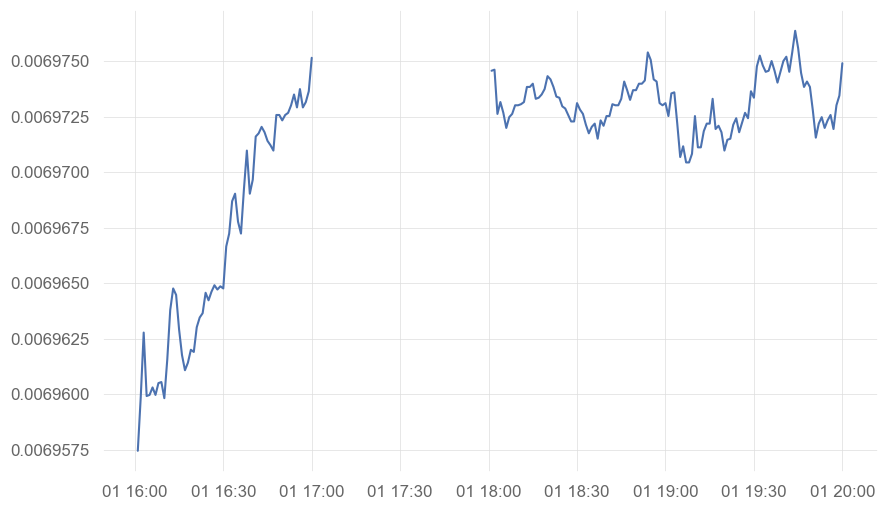

In [48]:
J6 = currencies_train['J6']

# check sample break in session

plt.figure(figsize = (10,6))
plt.plot(J6[960:1200])


C:\Users\hp\AppData\Local\Temp\ipykernel_3016\51189242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  J6.loc[J6.between_time("18:01", "18:05").index] = np.nan
C:\Users\hp\AppData\Local\Temp\ipykernel_3016\51189242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  J6.loc[J6.between_time("16:56", "17:00").index] = np.nan


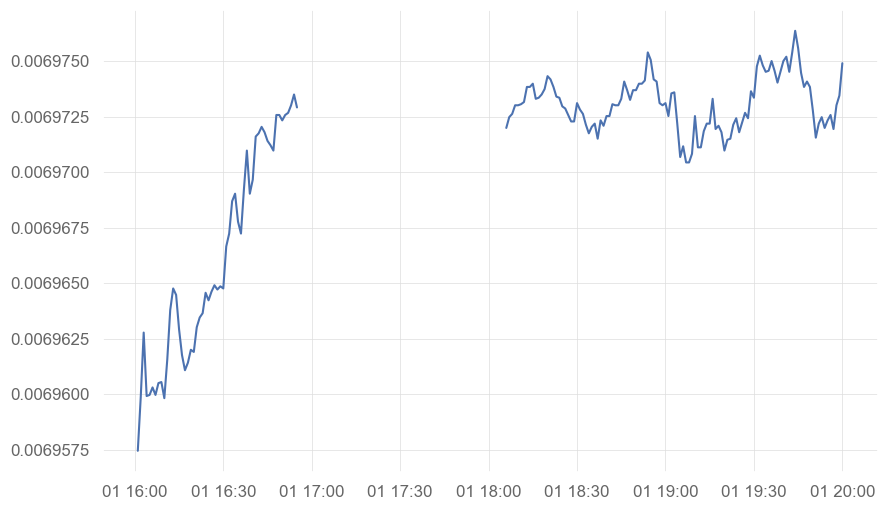

In [49]:
J6.loc[J6.between_time("18:01", "18:05").index] = np.nan
J6.loc[J6.between_time("16:56", "17:00").index] = np.nan

# let's see how the plot looks after inserting missing data

plt.figure(figsize = (10,6))
plt.plot(J6[960:1200])


In [50]:
pos_flat = np.zeros(len(J6))

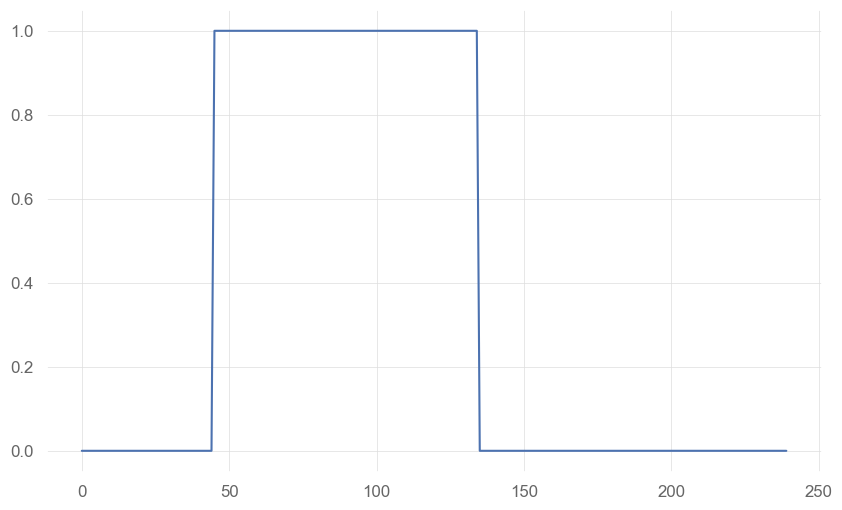

In [51]:
breaks = (J6.index.time >= pd.to_datetime("16:46").time()) & \
          (J6.index.time <= pd.to_datetime("18:15").time())

# Assign 1 to pos_flat where the breaks mask is True
pos_flat[breaks] = 1

# let's see an example break in the session from the perspective of pos_flat

plt.figure(figsize = (10,6))
plt.plot(pos_flat[960:1200])

In [52]:
dweek_ = J6.index.dayofweek + 1  # Adjust so that 0 = Monday, ..., 6 = Sunday
print(dweek_.value_counts())

datetime
4    12959
3    12957
2    12955
1    11520
5     9188
7     3771
Name: count, dtype: int64


In [53]:
time_ = J6.index.time

# and let's fill the pos_flat vector with ones for weekends

pos_flat[((dweek_ == 5) & (time_ > pd.to_datetime('17:00').time())) |      # end of Friday
          (dweek_ == 6) |                                                  # whole Saturday (just in case)
          ((dweek_ == 7) & (time_ <= pd.to_datetime('18:00').time()))] = 1 # beginning of Sunday

In [54]:
def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)

fastEMA_parameters = [15, 20, 30, 35, 40, 45, 50, 55, 60, 70, 75, 80, 85, 90]
slowEMA_parameters = [90, 120, 150, 180, 200, 240, 280, 300, 320, 360, 400, 420]

# create a dataframe to store results
summary_all_2MAs = pd.DataFrame()

# Loop over different parameter combinations
for fastEMA in fastEMA_parameters:
    for slowEMA in slowEMA_parameters:
                
                # ensure that fastEMA is less than slowEMA
                if fastEMA >= slowEMA:
                    continue

                print(f"fastEMA = {fastEMA}, slowEMA = {slowEMA}")

                # We calculate the appropriate EMA
                fastEMA_values = J6.ewm(span = fastEMA).mean()
                slowEMA_values = J6.ewm(span = slowEMA).mean()

                # Insert NaNs wherever the original price is missing
                fastEMA_values[J6.isna()] = np.nan
                slowEMA_values[J6.isna()] = np.nan 

                # Calculate position for momentum strategy
                cond2b_mom_long = fastEMA_values.shift(1) > slowEMA_values.shift(1)
                
                # let's add filters that check for the presence of NaN values
                fastEMA_nonmiss = fastEMA_values.shift(1).notna()
                slowEMA_nonmiss = slowEMA_values.shift(1).notna()

                # Now we can add these conditions to our strategies
                # if any of the values is missing,
                # we cannot make a position decision

                pos_mom = np.where(fastEMA_nonmiss & slowEMA_nonmiss,
                                   np.where(cond2b_mom_long, 1, -1),
                                   np.nan)
                pos_mr = -pos_mom 

                # Set position to 0 where pos_flat is 1
                pos_mom[pos_flat == 1] = 0
                pos_mr[pos_flat == 1] = 0
                
                # Calculate gross pnl
                pnl_gross_mom = np.where(np.isnan(pos_mom * J6.diff()), 0, pos_mom * J6.diff() * 125000) 
                pnl_gross_mr = np.where(np.isnan(pos_mr * J6.diff()), 0, pos_mr * J6.diff() * 125000) 
                # point value for E6

                # Calculate number of transactions
                ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                # Calculate net pnl
                pnl_net_mom = pnl_gross_mom - ntrans * 10  # cost $10 per transaction on E6
                pnl_net_mr = pnl_gross_mr - ntrans * 10  # cost $10 per transaction on E6
                  
                # Aggregate to daily data
                pnl_gross_mom = pd.Series(pnl_gross_mom)
                pnl_gross_mom.index = J6.index.time
                pnl_gross_mom_d = pnl_gross_mom.groupby(J6.index.date).sum()
                pnl_gross_mr = pd.Series(pnl_gross_mr)
                pnl_gross_mr.index = J6.index.time
                pnl_gross_mr_d = pnl_gross_mr.groupby(J6.index.date).sum()

                pnl_net_mom = pd.Series(pnl_net_mom)
                pnl_net_mom.index = J6.index.time
                pnl_net_mom_d = pnl_net_mom.groupby(J6.index.date).sum()
                pnl_net_mr = pd.Series(pnl_net_mr)
                pnl_net_mr.index = J6.index.time
                pnl_net_mr_d = pnl_net_mr.groupby(J6.index.date).sum()

                ntrans = pd.Series(ntrans)
                ntrans.index = J6.index.time
                ntrans_d = ntrans.groupby(J6.index.date).sum()

                # Calculate Sharpe Ratio and PnL
                gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                gross_PnL_mom = pnl_gross_mom_d.sum()
                net_PnL_mom = pnl_net_mom_d.sum()
                gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                gross_PnL_mr = pnl_gross_mr_d.sum()
                net_PnL_mr = pnl_net_mr_d.sum()

                av_daily_ntrans = ntrans_d.mean()

                # Collect necessary results into one object
                summary = pd.DataFrame({
                    'fastEMA': fastEMA,
                    'slowEMA': slowEMA,
                    'period': '2013-08',
                    'gross_SR_mom': gross_SR_mom,
                    'net_SR_mom': net_SR_mom,
                    'gross_PnL_mom': gross_PnL_mom,
                    'net_PnL_mom': net_PnL_mom,
                    'gross_SR_mr': gross_SR_mr,
                    'net_SR_mr': net_SR_mr,
                    'gross_PnL_mr': gross_PnL_mr,
                    'net_PnL_mr': net_PnL_mr,
                    'av_daily_ntrans': av_daily_ntrans
                }, index=[0])

                # Append results to the summary
                summary_all_2MAs = pd.concat([summary_all_2MAs, summary], ignore_index=True)

fastEMA = 15, slowEMA = 90
fastEMA = 15, slowEMA = 120
fastEMA = 15, slowEMA = 150
fastEMA = 15, slowEMA = 180
fastEMA = 15, slowEMA = 200
fastEMA = 15, slowEMA = 240
fastEMA = 15, slowEMA = 280
fastEMA = 15, slowEMA = 300
fastEMA = 15, slowEMA = 320
fastEMA = 15, slowEMA = 360
fastEMA = 15, slowEMA = 400
fastEMA = 15, slowEMA = 420
fastEMA = 20, slowEMA = 90
fastEMA = 20, slowEMA = 120
fastEMA = 20, slowEMA = 150
fastEMA = 20, slowEMA = 180
fastEMA = 20, slowEMA = 200
fastEMA = 20, slowEMA = 240
fastEMA = 20, slowEMA = 280
fastEMA = 20, slowEMA = 300
fastEMA = 20, slowEMA = 320
fastEMA = 20, slowEMA = 360
fastEMA = 20, slowEMA = 400
fastEMA = 20, slowEMA = 420
fastEMA = 30, slowEMA = 90
fastEMA = 30, slowEMA = 120
fastEMA = 30, slowEMA = 150
fastEMA = 30, slowEMA = 180
fastEMA = 30, slowEMA = 200
fastEMA = 30, slowEMA = 240
fastEMA = 30, slowEMA = 280
fastEMA = 30, slowEMA = 300
fastEMA = 30, slowEMA = 320
fastEMA = 30, slowEMA = 360
fastEMA = 30, slowEMA = 400
fastEMA = 30, slowEMA =

In [55]:
summary_all_2MAs.sort_values(by = 'net_SR_mr',
                            ascending = False).head(5)

,fastEMA,slowEMA,period,gross_SR_mom,net_SR_mom,gross_PnL_mom,net_PnL_mom,gross_SR_mr,net_SR_mr,gross_PnL_mr,net_PnL_mr,av_daily_ntrans
94,55,400,2013-08,2.632828,-24.307655,38.520612,-5841.419012,-2.632828,-26.171929,-38.520612,-5918.580988,11.094340
155,85,420,2013-08,2.388514,-24.226521,36.173192,-4643.766432,-2.388514,-26.679507,-36.173192,-4716.233568,8.830189
166,90,420,2013-08,2.290370,-24.656262,34.456532,-4725.483093,-2.290370,-27.239799,-34.456532,-4794.516907,8.981132
95,55,420,2013-08,2.723452,-25.397451,39.960086,-5619.979538,-2.723452,-27.631034,-39.960086,-5700.020462,10.679245
143,80,420,2013-08,2.538734,-24.963810,38.092328,-4841.847297,-2.538734,-27.632695,-38.092328,-4918.152703,9.207547


In [56]:
signalEMA_parameters = [20, 30, 35, 40, 45, 50, 55, 60, 70, 75, 80, 90]
slowEMA_parameters = [90, 120, 150, 160, 180, 240]
volat_sd_parameters = [60, 90, 120]
m_parameters = [1, 2, 3]

# create a dataframe to store results
summary_all_breakout = pd.DataFrame()

# loop over different parameter combinations
for signalEMA in signalEMA_parameters:
    print(f"signalEMA = {signalEMA}")
    for slowEMA in slowEMA_parameters:
        for volat_sd in volat_sd_parameters:
            for m in m_parameters:
               
                # We calculate the appropriate EMA
                signalEMA_values = J6.ewm(span = signalEMA).mean().to_numpy()
                slowEMA_values = J6.ewm(span = slowEMA).mean().to_numpy()
                                
                # We calculate the standard deviation
                volat_sd_values = J6.rolling(window = volat_sd).std().to_numpy()

                # Insert NaNs wherever the original price is missing
                signalEMA_values[J6.isna()] = np.nan
                slowEMA_values[J6.isna()] = np.nan 
                volat_sd_values[J6.isna()] = np.nan 

                # Calculate position for momentum strategy
                pos_mom = positionVB(signal = signalEMA_values, 
                                     lower = slowEMA_values - m * volat_sd_values,
                                     upper = slowEMA_values + m * volat_sd_values,
                                     pos_flat = pos_flat,
                                     strategy = "mom")
                
                pos_mr = -pos_mom 

                # Calculate gross pnl
                pnl_gross_mom = np.where(np.isnan(pos_mom * J6.diff()), 0, pos_mom * J6.diff() * 125000) 
                pnl_gross_mr = np.where(np.isnan(pos_mr * J6.diff()), 0, pos_mr * J6.diff() * 125000) 
                # point value for E6

                # Calculate number of transactions
                ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                # Calculate net pnl
                pnl_net_mom = pnl_gross_mom - ntrans * 10  # cost $10 per transaction on E6
                pnl_net_mr = pnl_gross_mr - ntrans * 10  # cost $10 per transaction on E6
                  
                # Aggregate to daily data
                pnl_gross_mom = pd.Series(pnl_gross_mom)
                pnl_gross_mom.index = J6.index.time
                pnl_gross_mom_d = pnl_gross_mom.groupby(J6.index.date).sum()
                pnl_gross_mr = pd.Series(pnl_gross_mr)
                pnl_gross_mr.index = J6.index.time
                pnl_gross_mr_d = pnl_gross_mr.groupby(J6.index.date).sum()

                pnl_net_mom = pd.Series(pnl_net_mom)
                pnl_net_mom.index = J6.index.time
                pnl_net_mom_d = pnl_net_mom.groupby(J6.index.date).sum()
                pnl_net_mr = pd.Series(pnl_net_mr)
                pnl_net_mr.index = J6.index.time
                pnl_net_mr_d = pnl_net_mr.groupby(J6.index.date).sum()

                ntrans = pd.Series(ntrans)
                ntrans.index = J6.index.time
                ntrans_d = ntrans.groupby(J6.index.date).sum()

                # Calculate Sharpe Ratio and PnL
                gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                gross_PnL_mom = pnl_gross_mom_d.sum()
                net_PnL_mom = pnl_net_mom_d.sum()
                gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                gross_PnL_mr = pnl_gross_mr_d.sum()
                net_PnL_mr = pnl_net_mr_d.sum()

                av_daily_ntrans = ntrans_d.mean()

                # Collect the necessary results into one object
                summary = pd.DataFrame({
                    'signalEMA': signalEMA,
                    'slowEMA': slowEMA,
                    'volat_sd': volat_sd,
                    'm': m,
                    'period': '2013-08',
                    'gross_SR_mom': gross_SR_mom,
                    'net_SR_mom': net_SR_mom,
                    'gross_PnL_mom': gross_PnL_mom,
                    'net_PnL_mom': net_PnL_mom,
                    'gross_SR_mr': gross_SR_mr,
                    'net_SR_mr': net_SR_mr,
                    'gross_PnL_mr': gross_PnL_mr,
                    'net_PnL_mr': net_PnL_mr,
                    'av_daily_ntrans': av_daily_ntrans
                }, index=[0])

                # Append the results to the summary
                summary_all_breakout = pd.concat([summary_all_breakout, summary], ignore_index=True)


signalEMA = 20
signalEMA = 30
signalEMA = 35
signalEMA = 40
signalEMA = 45
signalEMA = 50
signalEMA = 55
signalEMA = 60
signalEMA = 70
signalEMA = 75
signalEMA = 80
signalEMA = 90


In [57]:
summary_all_breakout.sort_values(by = 'net_SR_mr', 
                                 ascending = False).head(10)

,signalEMA,slowEMA,volat_sd,m,period,gross_SR_mom,net_SR_mom,gross_PnL_mom,net_PnL_mom,gross_SR_mr,net_SR_mr,gross_PnL_mr,net_PnL_mr,av_daily_ntrans
218,45,90,60,3,2013-08,2.201398,-2.201398,5.165206,-14.834794,-2.201398,-2.201398,-5.165206,-25.165206,0.037736
242,45,150,120,3,2013-08,-2.201398,-2.201398,-1.119302,-21.119302,2.201398,-2.201398,1.119302,-18.880698,0.037736
433,70,90,60,2,2013-08,-2.201398,-2.201398,-0.203040,-20.203040,2.201398,-2.201398,0.203040,-19.796960,0.037736
540,80,90,60,1,2013-08,-2.201398,-2.201398,-0.203040,-20.203040,2.201398,-2.201398,0.203040,-19.796960,0.037736
394,60,120,120,2,2013-08,-2.201398,-2.201398,-1.247078,-21.247078,2.201398,-2.201398,1.247078,-18.752922,0.037736
392,60,120,90,3,2013-08,-2.201398,-2.201398,-1.020593,-21.020593,2.201398,-2.201398,1.020593,-18.979407,0.037736
230,45,120,90,3,2013-08,-2.201398,-2.201398,-0.956734,-20.956734,2.201398,-2.201398,0.956734,-19.043266,0.037736
272,50,90,60,3,2013-08,-2.201398,-2.201398,-0.124091,-20.124091,2.201398,-2.201398,0.124091,-19.875909,0.037736
338,55,120,90,3,2013-08,-2.201398,-2.201398,-1.020593,-21.020593,2.201398,-2.201398,1.020593,-18.979407,0.037736
566,80,150,120,3,2013-08,-2.201398,-2.201398,-1.247078,-21.247078,2.201398,-2.201398,1.247078,-18.752922,0.037736


In [58]:
summary_all_breakout.sort_values(by = 'net_SR_mom',
                                 ascending = False).head(10)

,signalEMA,slowEMA,volat_sd,m,period,gross_SR_mom,net_SR_mom,gross_PnL_mom,net_PnL_mom,gross_SR_mr,net_SR_mr,gross_PnL_mr,net_PnL_mr,av_daily_ntrans
284,50,120,90,3,2013-08,-2.201398,-2.201398,-1.101881,-21.101881,2.201398,-2.201398,1.101881,-18.898119,0.037736
609,90,120,120,1,2013-08,-2.201398,-2.201398,-1.200610,-21.200610,2.201398,-2.201398,1.200610,-18.799390,0.037736
350,55,150,120,3,2013-08,-2.201398,-2.201398,-1.212226,-21.212226,2.201398,-2.201398,1.212226,-18.787774,0.037736
272,50,90,60,3,2013-08,-2.201398,-2.201398,-0.124091,-20.124091,2.201398,-2.201398,0.124091,-19.875909,0.037736
70,30,120,120,2,2013-08,-2.201398,-2.201398,-1.212226,-21.212226,2.201398,-2.201398,1.212226,-18.787774,0.037736
168,40,90,120,1,2013-08,-2.201398,-2.201398,-1.212226,-21.212226,2.201398,-2.201398,1.212226,-18.787774,0.037736
188,40,150,120,3,2013-08,-2.201398,-2.201398,-1.200610,-21.200610,2.201398,-2.201398,1.200610,-18.799390,0.037736
134,35,150,120,3,2013-08,-2.201398,-2.201398,-1.200610,-21.200610,2.201398,-2.201398,1.200610,-18.799390,0.037736
124,35,120,120,2,2013-08,-2.201398,-2.201398,-1.212226,-21.212226,2.201398,-2.201398,1.212226,-18.787774,0.037736
80,30,150,120,3,2013-08,-2.201398,-2.201398,-1.200610,-21.200610,2.201398,-2.201398,1.200610,-18.799390,0.037736


In [59]:
summary_all_breakout["signalEMA_slowEMA"] = (
    summary_all_breakout["signalEMA"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout["slowEMA"].astype(int).astype(str).str.zfill(3)
)

summary_all_breakout["volat_sd_m"] = (
    summary_all_breakout["volat_sd"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout["m"].astype(str)
)

summary_all_breakout.head()

,signalEMA,slowEMA,volat_sd,m,period,gross_SR_mom,net_SR_mom,gross_PnL_mom,net_PnL_mom,gross_SR_mr,net_SR_mr,gross_PnL_mr,net_PnL_mr,av_daily_ntrans,signalEMA_slowEMA,volat_sd_m
0,20,90,60,1,2013-08,2.314826,-32.906512,27.291888,-4762.708112,-2.314826,-35.797458,-27.291888,-4817.291888,9.037736,020_090,060_1
1,20,90,60,2,2013-08,-1.636868,-17.022658,-15.715608,-1165.715608,1.636868,-19.270445,15.715608,-1134.284392,2.169811,020_090,060_2
2,20,90,60,3,2013-08,4.072904,-8.051593,15.899637,-204.100363,-4.072904,-8.069626,-15.899637,-235.899637,0.415094,020_090,060_3
3,20,90,90,1,2013-08,4.444995,-32.488904,47.789096,-3782.210904,-4.444995,-34.835776,-47.789096,-3877.789096,7.226415,020_090,090_1
4,20,90,90,2,2013-08,0.994345,-3.886930,0.439883,-59.560117,-0.994345,-3.886973,-0.439883,-60.439883,0.113208,020_090,090_2


In [67]:
best_row = summary_all_breakout.loc[summary_all_breakout['net_SR_mr'].idxmax()]

if isinstance(best_row['signalEMA_slowEMA'], str):
    signal_ema, slow_ema = best_row['signalEMA_slowEMA'].split('_')

    print(f"signalEMA: {signal_ema}")
    print(f"slowEMA: {slow_ema}")


signalEMA: 045
slowEMA: 090


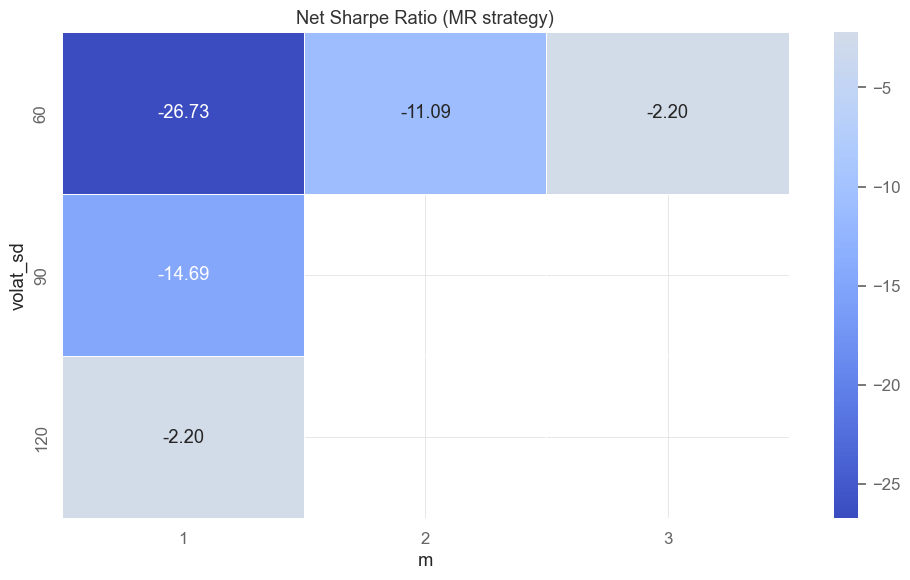

In [68]:
summary_all_breakout_wybrane = summary_all_breakout[
    (summary_all_breakout['signalEMA'] == 45) & (summary_all_breakout['slowEMA'] == 90)
]

# and we create a heatmap for them
plot_heatmap(
    summary_all_breakout_wybrane,
    value_col = 'net_SR_mr',
    index_col = 'volat_sd',
    columns_col = 'm',
    title = 'Net Sharpe Ratio (MR strategy)',
    cmap = "coolwarm"
)

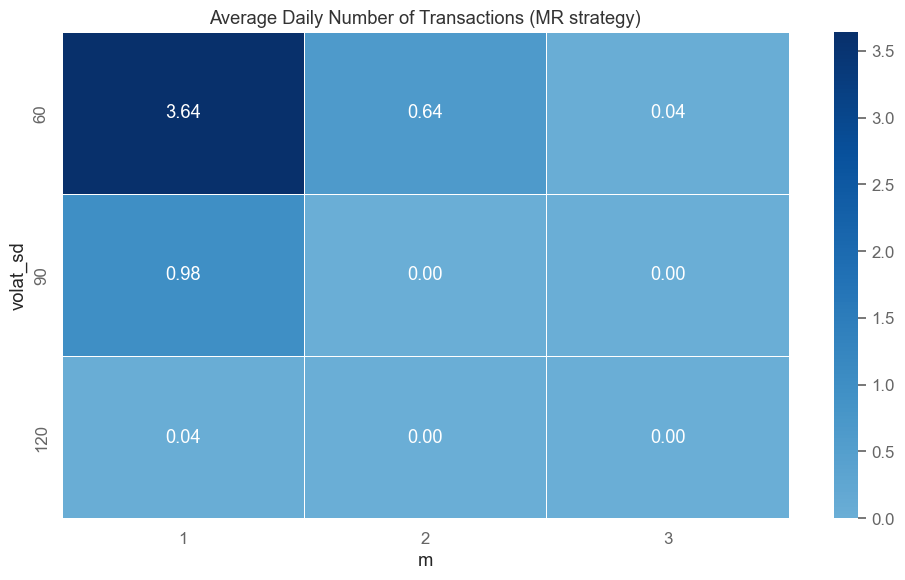

In [ ]:
plot_heatmap(
    summary_all_breakout_wybrane,
    value_col = 'av_daily_ntrans',
    index_col = 'volat_sd',
    columns_col = 'm',
    title = 'Average Daily Number of Transactions (MR strategy)',
    cmap = "Blues")

J6 performs worse than that of E6 under the same strategy and it has fewer transactions.

# Exercise 7.3

Analyze a mean-reverting strategy for a spread between the Canadian dollar C6 and the Australian dollar A6 (assume the simplest form: C6-A6).

Remember that transaction costs are ALWAYS positive, regardless of whether you are long or short.

In [70]:
C6 = currencies_train['C6']
A6 = currencies_train['A6']

In [75]:
spread = C6 - A6

In [76]:
spread.loc[spread.between_time("18:01", "18:05").index] = np.nan
spread.loc[spread.between_time("16:56", "17:00").index] = np.nan

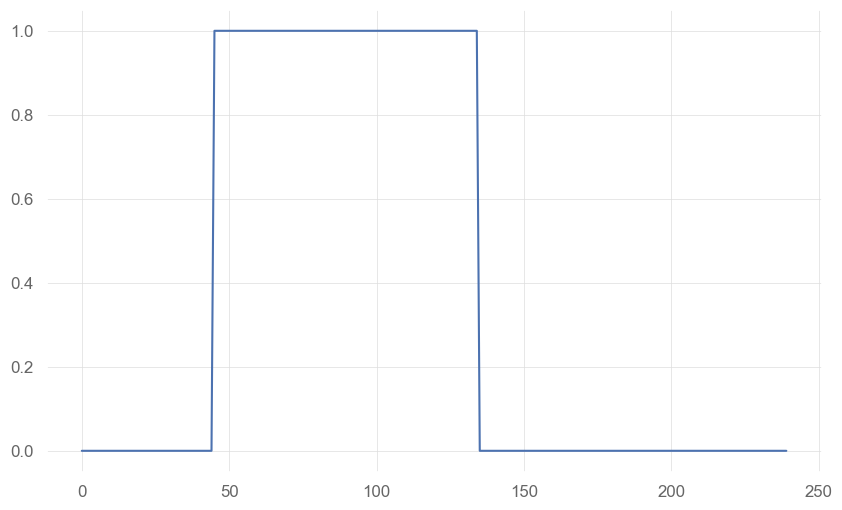

In [77]:
breaks = (spread.index.time >= pd.to_datetime("16:46").time()) & \
          (spread.index.time <= pd.to_datetime("18:15").time())

# Assign 1 to pos_flat where the breaks mask is True
pos_flat[breaks] = 1

# let's see an example break in the session from the perspective of pos_flat

plt.figure(figsize = (10,6))
plt.plot(pos_flat[960:1200])

In [78]:
pos_flat = np.zeros(len(spread))

In [79]:
dweek_ = spread.index.dayofweek + 1  # Adjust so that 0 = Monday, ..., 6 = Sunday
print(dweek_.value_counts())

datetime
4    12959
3    12957
2    12955
1    11520
5     9188
7     3771
Name: count, dtype: int64


In [80]:
time_ = spread.index.time

# and let's fill the pos_flat vector with ones for weekends

pos_flat[((dweek_ == 5) & (time_ > pd.to_datetime('17:00').time())) |      # end of Friday
          (dweek_ == 6) |                                                  # whole Saturday (just in case)
          ((dweek_ == 7) & (time_ <= pd.to_datetime('18:00').time()))] = 1 # beginning of Sunday

In [81]:
def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)

fastEMA_parameters = [15, 20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240, 300, 360, 420]

# create a dataframe to store results
summary_all_2MAs = pd.DataFrame()

# Loop over different parameter combinations
for fastEMA in fastEMA_parameters:
    for slowEMA in slowEMA_parameters:
                
                # ensure that fastEMA is less than slowEMA
                if fastEMA >= slowEMA:
                    continue

                print(f"fastEMA = {fastEMA}, slowEMA = {slowEMA}")

                # We calculate the appropriate EMA
                fastEMA_values = spread.ewm(span = fastEMA).mean()
                slowEMA_values = spread.ewm(span = slowEMA).mean()

                # Insert NaNs wherever the original price is missing
                fastEMA_values[spread.isna()] = np.nan
                slowEMA_values[spread.isna()] = np.nan 

                # Calculate position for momentum strategy
                cond2b_mom_long = fastEMA_values.shift(1) > slowEMA_values.shift(1)
                
                # let's add filters that check for the presence of NaN values
                fastEMA_nonmiss = fastEMA_values.shift(1).notna()
                slowEMA_nonmiss = slowEMA_values.shift(1).notna()

                # Now we can add these conditions to our strategies
                # if any of the values is missing,
                # we cannot make a position decision

                pos_mom = np.where(fastEMA_nonmiss & slowEMA_nonmiss,
                                   np.where(cond2b_mom_long, 1, -1),
                                   np.nan)
                pos_mr = -pos_mom 

                # Set position to 0 where pos_flat is 1
                pos_mom[pos_flat == 1] = 0
                pos_mr[pos_flat == 1] = 0
                
                # Calculate gross pnl
                pnl_gross_mom = np.where(np.isnan(pos_mom * spread.diff()), 0, pos_mom * spread.diff() * 125000) 
                pnl_gross_mr = np.where(np.isnan(pos_mr * spread.diff()), 0, pos_mr * spread.diff() * 125000) 
                # point value for E6

                # Calculate number of transactions
                ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                # Calculate net pnl
                pnl_net_mom = pnl_gross_mom - ntrans * 10  # cost $10 per transaction on E6
                pnl_net_mr = pnl_gross_mr - ntrans * 10  # cost $10 per transaction on E6
                  
                # Aggregate to daily data
                pnl_gross_mom = pd.Series(pnl_gross_mom)
                pnl_gross_mom.index = spread.index.time
                pnl_gross_mom_d = pnl_gross_mom.groupby(spread.index.date).sum()
                pnl_gross_mr = pd.Series(pnl_gross_mr)
                pnl_gross_mr.index = spread.index.time
                pnl_gross_mr_d = pnl_gross_mr.groupby(spread.index.date).sum()

                pnl_net_mom = pd.Series(pnl_net_mom)
                pnl_net_mom.index = spread.index.time
                pnl_net_mom_d = pnl_net_mom.groupby(spread.index.date).sum()
                pnl_net_mr = pd.Series(pnl_net_mr)
                pnl_net_mr.index = spread.index.time
                pnl_net_mr_d = pnl_net_mr.groupby(spread.index.date).sum()

                ntrans = pd.Series(ntrans)
                ntrans.index = spread.index.time
                ntrans_d = ntrans.groupby(spread.index.date).sum()

                # Calculate Sharpe Ratio and PnL
                gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                gross_PnL_mom = pnl_gross_mom_d.sum()
                net_PnL_mom = pnl_net_mom_d.sum()
                gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                gross_PnL_mr = pnl_gross_mr_d.sum()
                net_PnL_mr = pnl_net_mr_d.sum()

                av_daily_ntrans = ntrans_d.mean()

                # Collect necessary results into one object
                summary = pd.DataFrame({
                    'fastEMA': fastEMA,
                    'slowEMA': slowEMA,
                    'period': '2013-08',
                    'gross_SR_mom': gross_SR_mom,
                    'net_SR_mom': net_SR_mom,
                    'gross_PnL_mom': gross_PnL_mom,
                    'net_PnL_mom': net_PnL_mom,
                    'gross_SR_mr': gross_SR_mr,
                    'net_SR_mr': net_SR_mr,
                    'gross_PnL_mr': gross_PnL_mr,
                    'net_PnL_mr': net_PnL_mr,
                    'av_daily_ntrans': av_daily_ntrans
                }, index=[0])

                # Append results to the summary
                summary_all_2MAs = pd.concat([summary_all_2MAs, summary], ignore_index=True)

fastEMA = 15, slowEMA = 90
fastEMA = 15, slowEMA = 120
fastEMA = 15, slowEMA = 150
fastEMA = 15, slowEMA = 180
fastEMA = 15, slowEMA = 240
fastEMA = 15, slowEMA = 300
fastEMA = 15, slowEMA = 360
fastEMA = 15, slowEMA = 420
fastEMA = 20, slowEMA = 90
fastEMA = 20, slowEMA = 120
fastEMA = 20, slowEMA = 150
fastEMA = 20, slowEMA = 180
fastEMA = 20, slowEMA = 240
fastEMA = 20, slowEMA = 300
fastEMA = 20, slowEMA = 360
fastEMA = 20, slowEMA = 420
fastEMA = 30, slowEMA = 90
fastEMA = 30, slowEMA = 120
fastEMA = 30, slowEMA = 150
fastEMA = 30, slowEMA = 180
fastEMA = 30, slowEMA = 240
fastEMA = 30, slowEMA = 300
fastEMA = 30, slowEMA = 360
fastEMA = 30, slowEMA = 420
fastEMA = 45, slowEMA = 90
fastEMA = 45, slowEMA = 120
fastEMA = 45, slowEMA = 150
fastEMA = 45, slowEMA = 180
fastEMA = 45, slowEMA = 240
fastEMA = 45, slowEMA = 300
fastEMA = 45, slowEMA = 360
fastEMA = 45, slowEMA = 420
fastEMA = 60, slowEMA = 90
fastEMA = 60, slowEMA = 120
fastEMA = 60, slowEMA = 150
fastEMA = 60, slowEMA = 1

In [82]:
summary_all_2MAs.sort_values(by = 'net_SR_mr',
                            ascending = False).head(5)

,fastEMA,slowEMA,period,gross_SR_mom,net_SR_mom,gross_PnL_mom,net_PnL_mom,gross_SR_mr,net_SR_mr,gross_PnL_mr,net_PnL_mr,av_daily_ntrans
53,90,360,2013-08,-4.428542,-8.176557,-4620.228947,-9751.302264,4.428542,-0.703062,4620.228947,-648.697736,9.811321
45,75,300,2013-08,-4.917961,-9.081208,-5396.562779,-11830.672370,4.917961,-1.175975,5396.562779,-1089.327630,12.188679
39,60,420,2013-08,-3.843985,-7.512641,-4163.735675,-9430.460919,3.843985,-1.284296,4163.735675,-1209.539081,10.037736
52,90,300,2013-08,-4.021255,-7.859650,-4444.888693,-10051.498284,4.021255,-1.325826,4444.888693,-1268.501716,10.679245
47,75,420,2013-08,-3.620186,-7.195213,-3744.602670,-8595.675987,3.620186,-1.377277,3744.602670,-1244.324013,9.283019


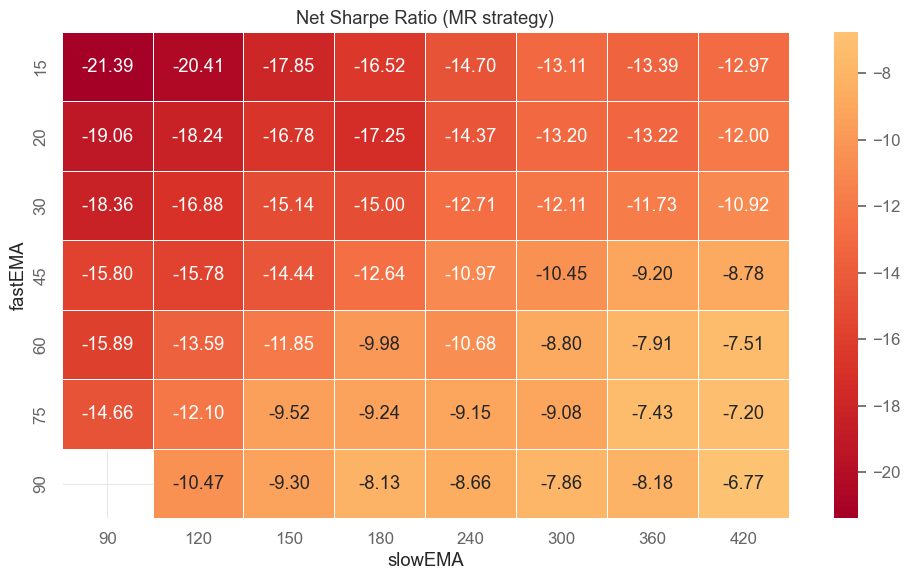

In [83]:
plot_heatmap(
    summary_all_2MAs,
    value_col = 'net_SR_mom',
    index_col = 'fastEMA',
    columns_col = 'slowEMA',
    title = 'Net Sharpe Ratio (MR strategy)'
)

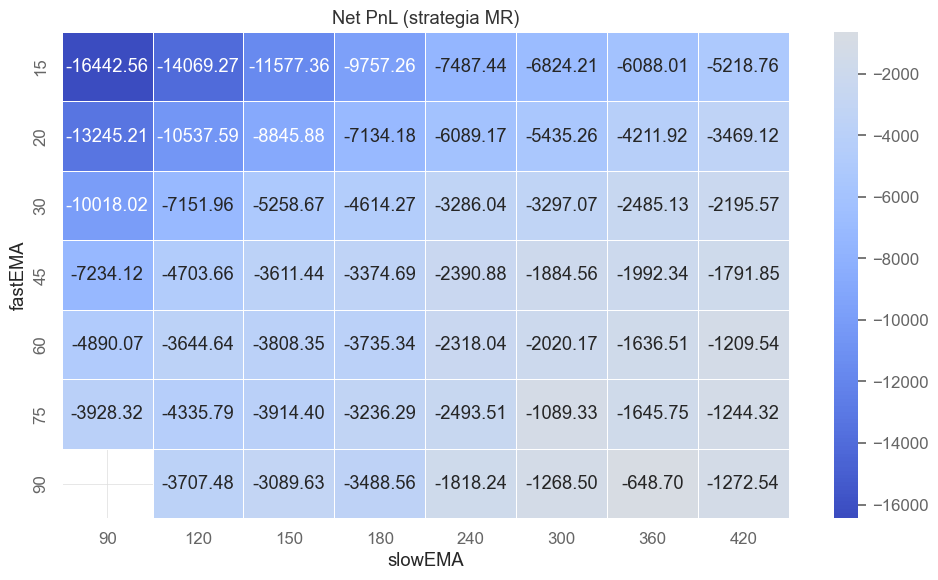

In [84]:
plot_heatmap(
    summary_all_2MAs,
    value_col = 'net_PnL_mr',
    index_col = 'fastEMA',
    columns_col = 'slowEMA',
    cmap = "coolwarm",
    title = 'Net PnL (strategia MR)'
)